# Classifying credit markets with macro factors

## Get packages and JPMaQS data

In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import make_scorer, balanced_accuracy_score

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.pnl as msn
import macrosynergy.signal as mss
import macrosynergy.learning as msl
import macrosynergy.visuals as msv

from macrosynergy.download import JPMaQSDownload

import warnings

warnings.simplefilter("ignore")

In [2]:
# Cross-sections
cids_dm = ["USD", "EUR"]
cids_ig = ["UIG", "EIG"]
cids_hy = ["UHY", "EHY"]
cids_cr = ["UIG", "UHY", "EIG", "EHY"]

cids = cids_cr + cids_dm

In [3]:
# Indicator categories

rates = [
    "RYLDIRS02Y_NSA",
    "RYLDIRS05Y_NSA",
]

hpi = [
    "HPI_SA_P6M6ML6AR",
    "HPI_SA_P2Q2QL2AR",
    "HPI_SA_P1M1ML12",
    "HPI_SA_P1Q1QL4",
]

bsurv_changes = [
    # Construction confidence
    "CBCSCORE_SA_D6M6ML6",
    "CBCSCORE_SA_D3M3ML3",
    # Manufacturing confidence
    "MBCSCORE_SA_D6M6ML6",
    "MBCSCORE_SA_D3M3ML3",
    # Services confidence
    "SBCSCORE_SA_D6M6ML6",
    "SBCSCORE_SA_D3M3ML3",
]

csurv_changes = [
    "CCSCORE_SA_D6M6ML6",
    "CCSCORE_SA_D3M3ML3",
]

bank_lending = [
    "BLSCSCORE_NSA",
    "BLSCSCORE_NSA_D2Q2QL2",
    "BLSCSCORE_NSA_D1Q1QL4",
]

credit = [
    "PCREDITBN_SJA_P1M1ML12",
    "PCREDITBN_SJA_P1M1ML12_D1M1ML12",
]

main = rates + hpi + bsurv_changes + csurv_changes + bank_lending + credit

econ = [
    "INFTEFF_NSA",
    "INTRGDP_NSA_P1M1ML12_3MMA",
    "RGDP_SA_P1Q1QL4_20QMA",
]
mark = [
    "CRXR_VT10",
    "CRXR_NSA",
    "CRCRY_NSA",
]

xcats = main + econ + mark

In [4]:
# Tickers for download

single_tix = ["USD_GB10YXR_NSA", "USD_EQXR_NSA"]
tickers = (
    [cid + "_" + xcat for cid in cids_dm for xcat in main + econ]
    + [cid + "_" + xcat for cid in cids_cr for xcat in mark]
    + single_tix
)

In [5]:
# Download series from J.P. Morgan DataQuery by tickers

start_date = "2000-01-01"
end_date = None

# Retrieve credentials

oauth_id = os.getenv("DQ_CLIENT_ID")  # Replace with own client ID
oauth_secret = os.getenv("DQ_CLIENT_SECRET")  # Replace with own secret

# Download from DataQuery

downloader = JPMaQSDownload(client_id=oauth_id, client_secret=oauth_secret)
df = downloader.download(
    tickers=tickers,
    start_date=start_date,
    end_date=end_date,
    metrics=["value"],
    suppress_warning=True,
    show_progress=True,
)

dfd = df.copy()
dfd.info()

Timestamp UTC:  2025-02-14 15:28:31
Connection successful!


Requesting data: 100%|███████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Some expressions are missing from the downloaded data. Check logger output for complete list.
4 out of 58 expressions are missing. To download the catalogue of all available expressions and filter the unavailable expressions, set `get_catalogue=True` in the call to `JPMaQSDownload.download()`.
Some dates are missing from the downloaded data. 
2 out of 6557 dates are missing.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338824 entries, 0 to 338823
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   real_date  338824 non-null  datetime64[ns]
 1   cid        338824 non-null  object        
 2   xcat       338824 non-null  object        
 3   value      338824 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 10.3+ MB


## Availability

### Renaming

In [6]:
# Rename quarterly tickers to roughly equivalent monthly tickers

dict_repl = {
    "HPI_SA_P1Q1QL4": "HPI_SA_P1M1ML12",
    "HPI_SA_P2Q2QL2AR": "HPI_SA_P6M6ML6AR",
}

for key, value in dict_repl.items():
    dfd["xcat"] = dfd["xcat"].str.replace(key, value)

In [7]:
# Rename and duplicate economic area tickers in accordance with credit market tickers

dfa = dfd[
    (dfd["cid"].isin(["EUR", "USD"])) & ~(dfd["xcat"].isin(["EQXR_NSA", "GB10YXR_NSA"]))
]

dfa_ig = dfa.replace({"^EUR": "EIG", "^USD": "UIG"}, regex=True)
dfa_hy = dfa.replace({"^EUR": "EHY", "^USD": "UHY"}, regex=True)

dfx = pd.concat([dfd, dfa_ig, dfa_hy])

### Check availability

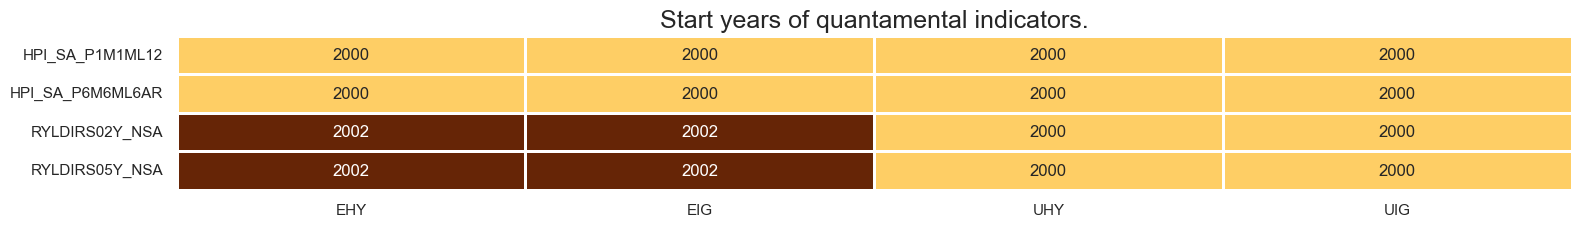

In [8]:
xcatx = rates + hpi
cidx = cids_cr

msm.check_availability(df=dfx, xcats=xcatx, cids=cidx, missing_recent=False)

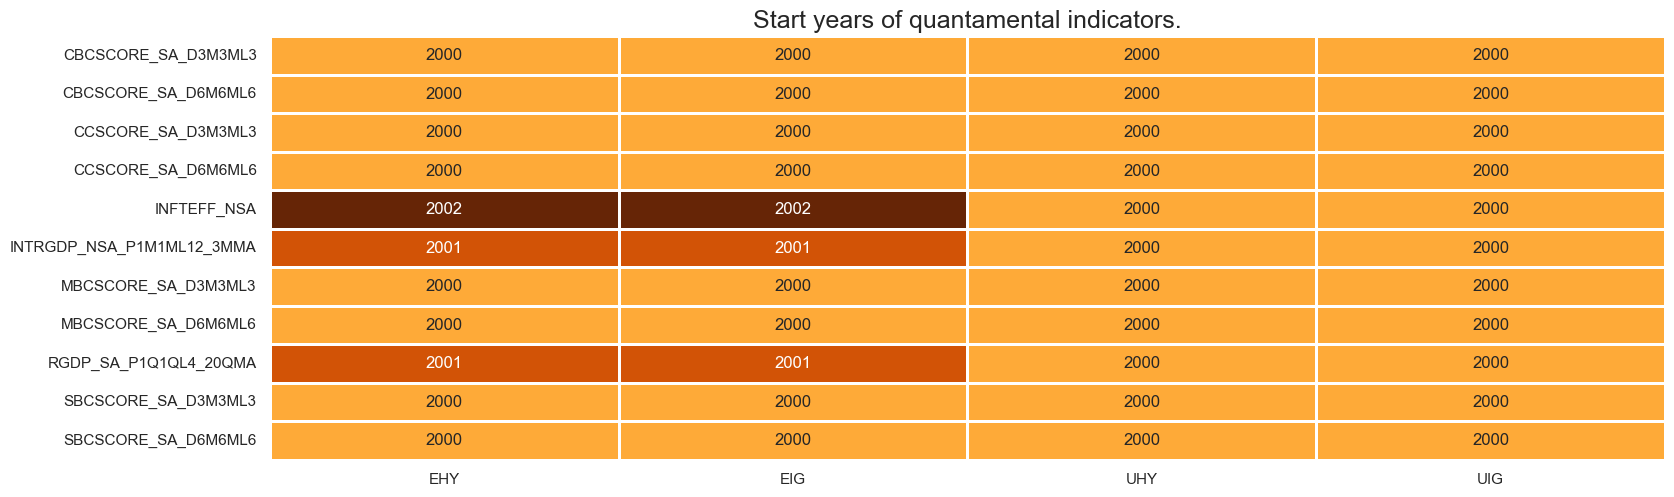

In [9]:
xcatx = bsurv_changes + csurv_changes + econ
cidx = cids_cr

msm.check_availability(df=dfx, xcats=xcatx, cids=cidx, missing_recent=False)

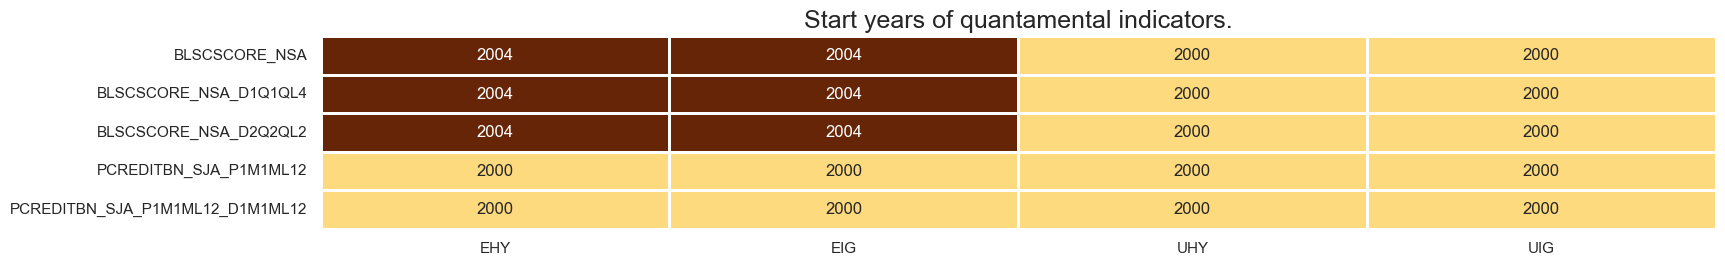

In [10]:
xcatx = bank_lending + credit
cidx = cids_cr

msm.check_availability(df=dfx, xcats=xcatx, cids=cidx, missing_recent=False)

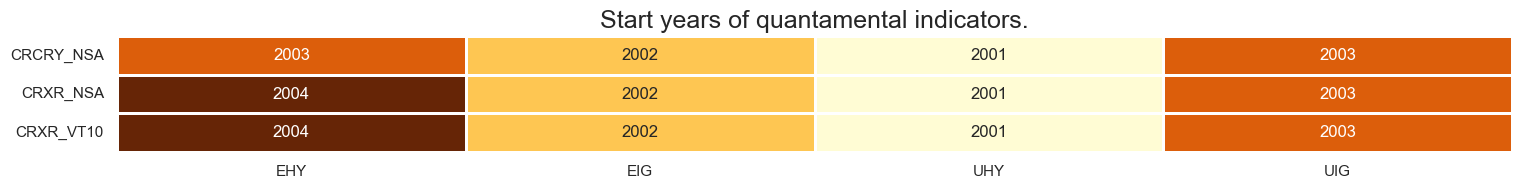

In [11]:
xcatx = mark
cidx = cids_cr

msm.check_availability(df=dfx, xcats=xcatx, cids=cidx, missing_recent=False)

## Factor computation and checks

### Single-concept calculations

In [12]:
factors = []

#### Business sentiment dynamics

In [13]:
# Annualize sentiment score changes

cidx = cids_cr
calcs = []

bss = ["CBCSCORE_SA", "MBCSCORE_SA", "SBCSCORE_SA"]
for bs in bss:
    calcs.append(f"{bs}_D6M6ML6AR = {bs}_D6M6ML6 * 2")
    calcs.append(f"{bs}_D3M3ML3AR = {bs}_D3M3ML3 * 4")

dfa = msp.panel_calculator(df=dfx, calcs=calcs, cids=cidx)
dfx = msm.update_df(dfx, dfa)

bsar = [f"{bs}_D6M6ML6AR" for bs in bss] + [f"{bs}_D3M3ML3AR" for bs in bss]

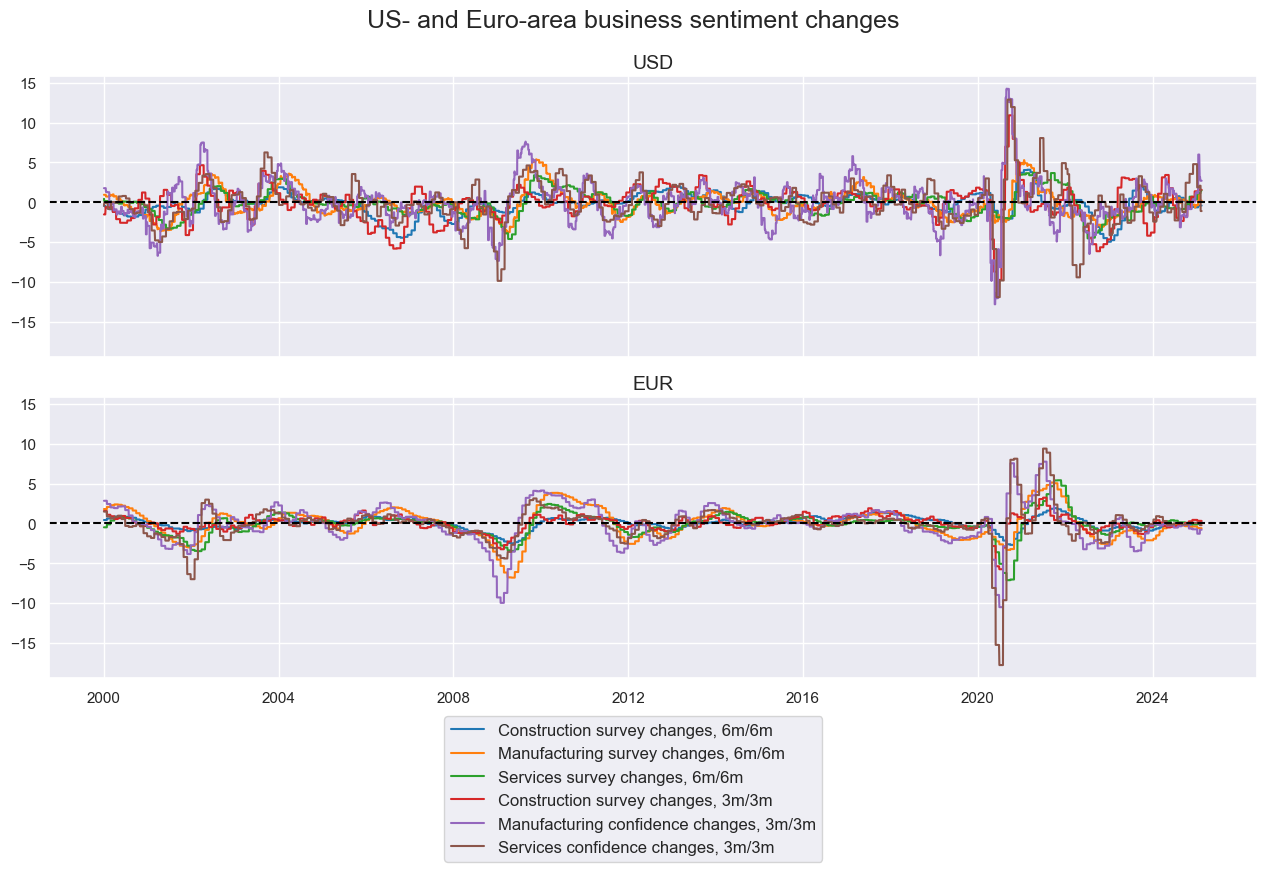

In [14]:
cidx = ["UIG", "EIG"]
xcatx = bsar

msp.view_timelines(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=1,
    same_y=True,
    aspect=3,
    title="US- and Euro-area business sentiment changes",
    xcat_labels=[
        "Construction survey changes, 6m/6m",
        "Manufacturing survey changes, 6m/6m",
        "Services survey changes, 6m/6m",
        "Construction survey changes, 3m/3m",
        "Manufacturing confidence changes, 3m/3m",
        "Services confidence changes, 3m/3m",
    ],
    cid_labels=["USD", "EUR"],
)

In [15]:
# Single business sentiment change
cidx = cids_cr
xcatx = bsar

dfa = msp.linear_composite(df=dfx, xcats=xcatx, cids=cids_cr, new_xcat="BCONFCHG")
dfx = msm.update_df(dfx, dfa)

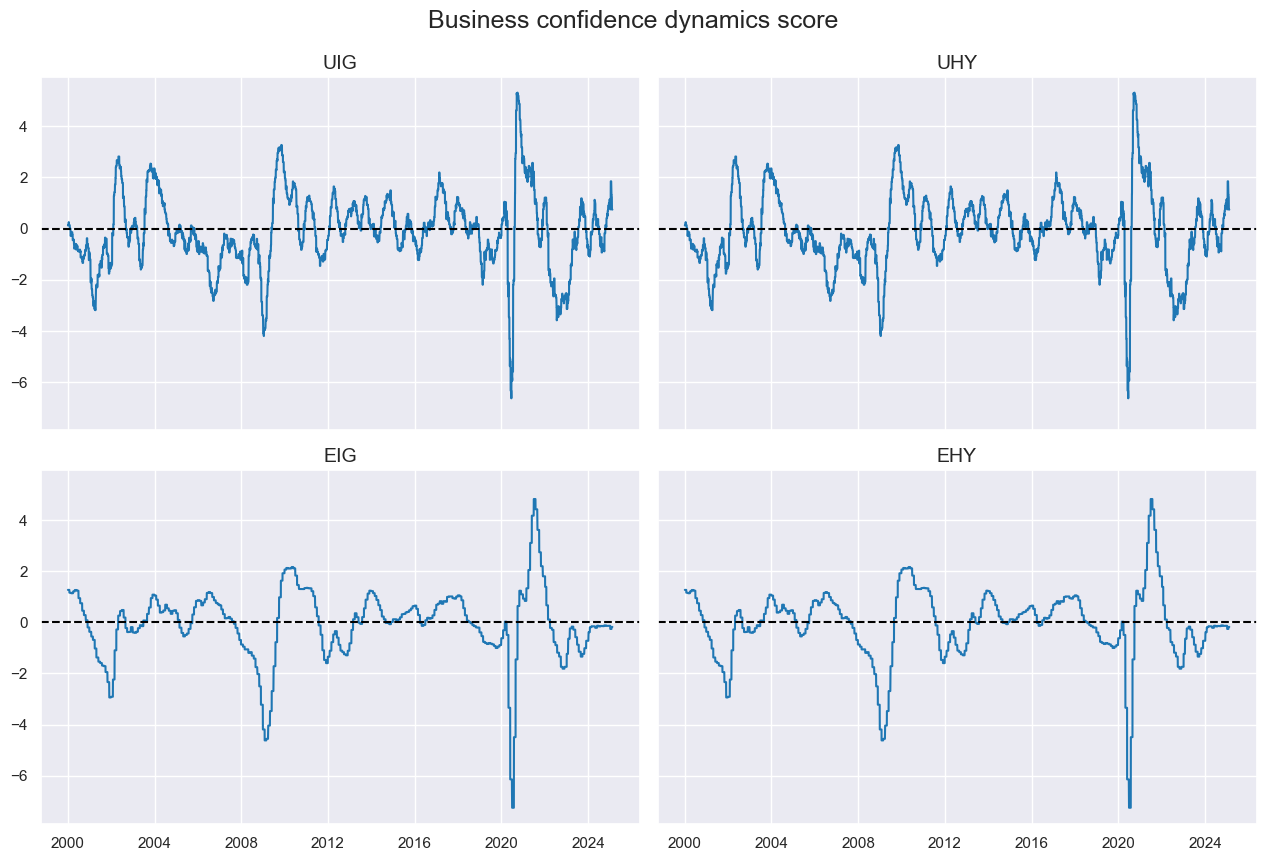

In [16]:
cidx = cids_cr
xcatx = ["BCONFCHG"]

msp.view_timelines(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    title="Business confidence dynamics score",
    ncol=2,
    same_y=True,
    aspect=1.5,
)

#### Excess house price trends

In [17]:
# Excess house price growth

cidx = cids_cr
calcs = []

calcs.append(f"XHPI_SA_P1M1ML12 = HPI_SA_P1M1ML12 - INFTEFF_NSA")
calcs.append(f"XHPI_SA_P6M6ML6AR = HPI_SA_P6M6ML6AR - INFTEFF_NSA")

dfa = msp.panel_calculator(df=dfx, calcs=calcs, cids=cidx)
dfx = msm.update_df(dfx, dfa)

xhpi = ["XHPI_SA_P1M1ML12", "XHPI_SA_P6M6ML6AR"]

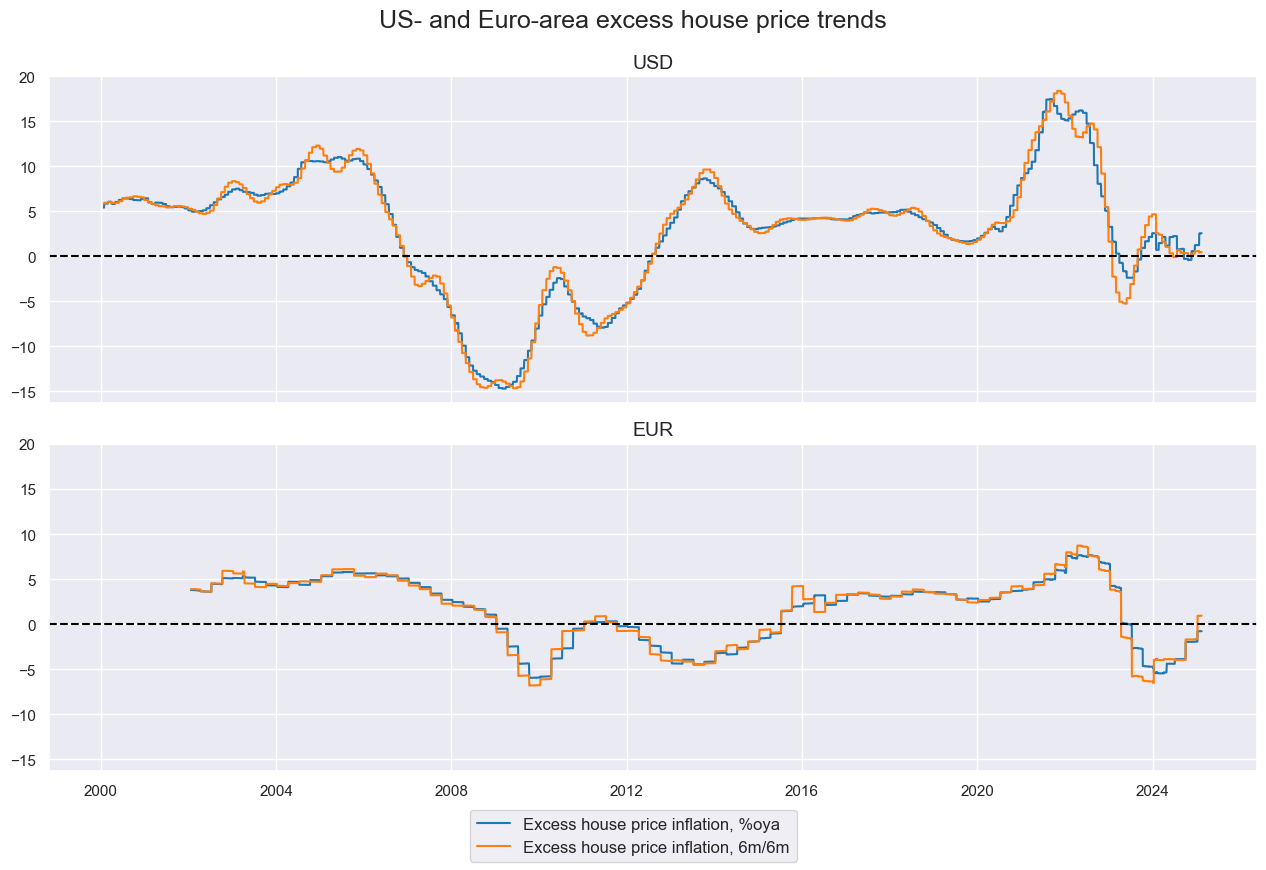

In [18]:
cidx = ["UIG", "EIG"]
xcatx = xhpi

msp.view_timelines(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    title="US- and Euro-area excess house price trends",
    ncol=1,
    same_y=True,
    aspect=3,
    xcat_labels=[
        "Excess house price inflation, %oya",
        "Excess house price inflation, 6m/6m",
    ],
    cid_labels=["USD", "EUR"],
)

In [19]:
xcatx = xhpi
cidx = cids_cr

dfa = msp.linear_composite(df=dfx, xcats=xcatx, cids=cidx, new_xcat="XHPI")
dfx = msm.update_df(dfx, dfa)

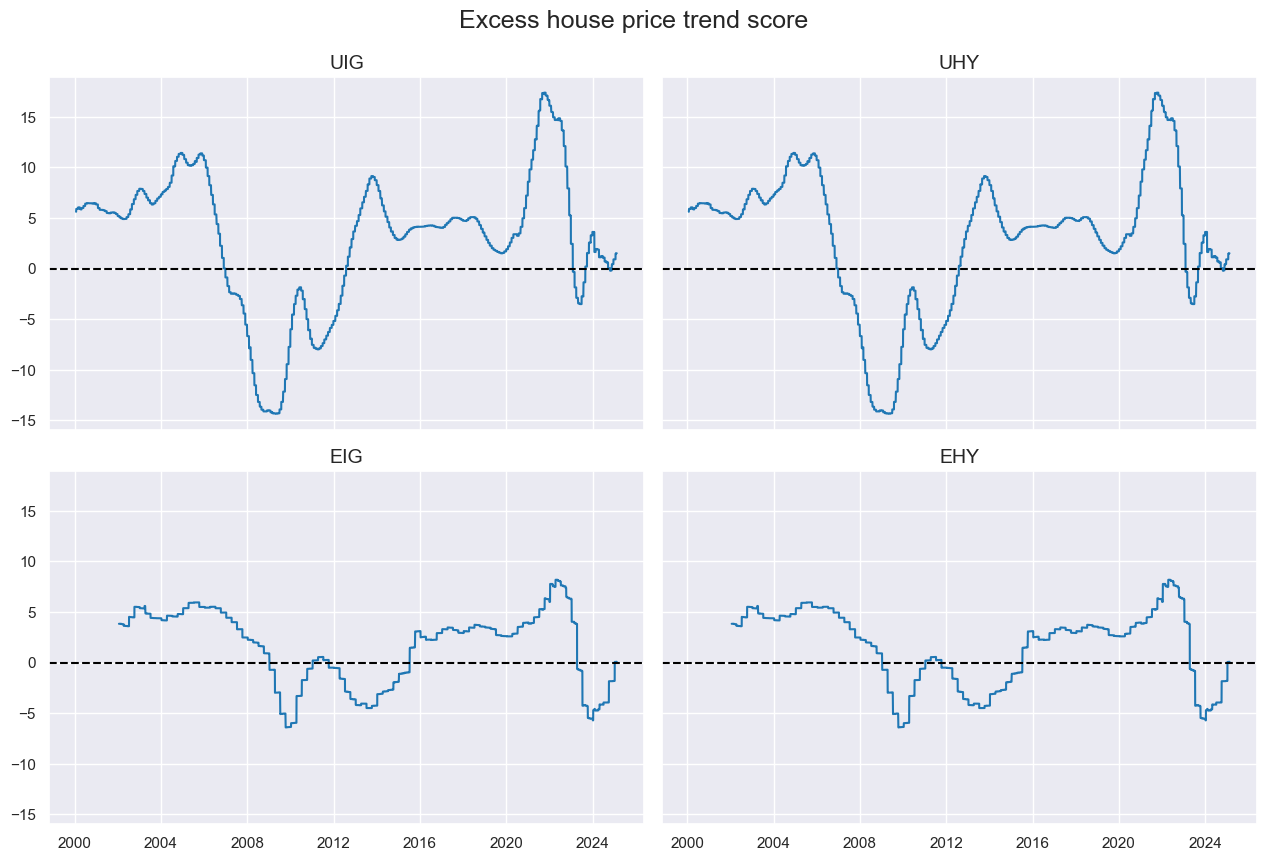

In [20]:
cidx = cids_cr
xcatx = ["XHPI"]

msp.view_timelines(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    title="Excess house price trend score",
    ncol=2,
    same_y=True,
    aspect=1.5,
)

#### Real interest rate conditions

In [21]:
# Real rates versus 3-year averages

cidx = cids_cr
calcs = []

for rate in rates:
    calcs.append(f"X{rate}_NEG = - {rate} + RGDP_SA_P1Q1QL4_20QMA")
    calcs.append(f"XX{rate}_NEG = - {rate} + 2")

dfa = msp.panel_calculator(df=dfx, calcs=calcs, cids=cidx)
dfx = msm.update_df(dfx, dfa)

xratns = [f"{x}{rate}_NEG" for rate in rates for x in ["X", "XX"]]

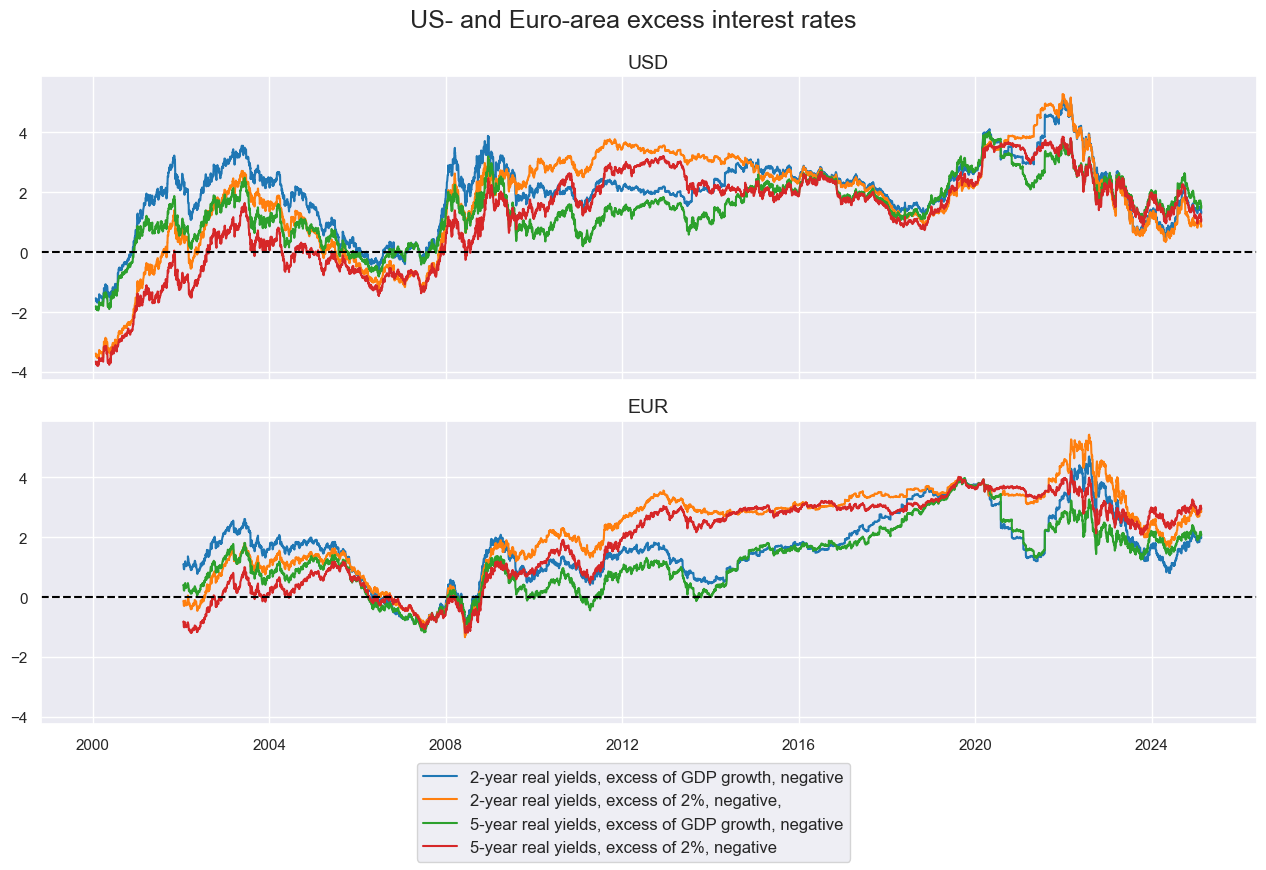

In [22]:
cidx = ["UIG", "EIG"]
xcatx = xratns

msp.view_timelines(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    title="US- and Euro-area excess interest rates",
    ncol=1,
    same_y=True,
    aspect=3,
    xcat_labels=[
        "2-year real yields, excess of GDP growth, negative",
        "2-year real yields, excess of 2%, negative,",
        "5-year real yields, excess of GDP growth, negative",
        "5-year real yields, excess of 2%, negative",
    ],
    cid_labels=["USD", "EUR"],
)

In [23]:
# Composite excess real interest rate measure

xcatx = xratns
cidx = cids_cr

dfa = msp.linear_composite(df=dfx, xcats=xcatx, cids=cidx, new_xcat="XRATES_NEG")
dfx = msm.update_df(dfx, dfa)

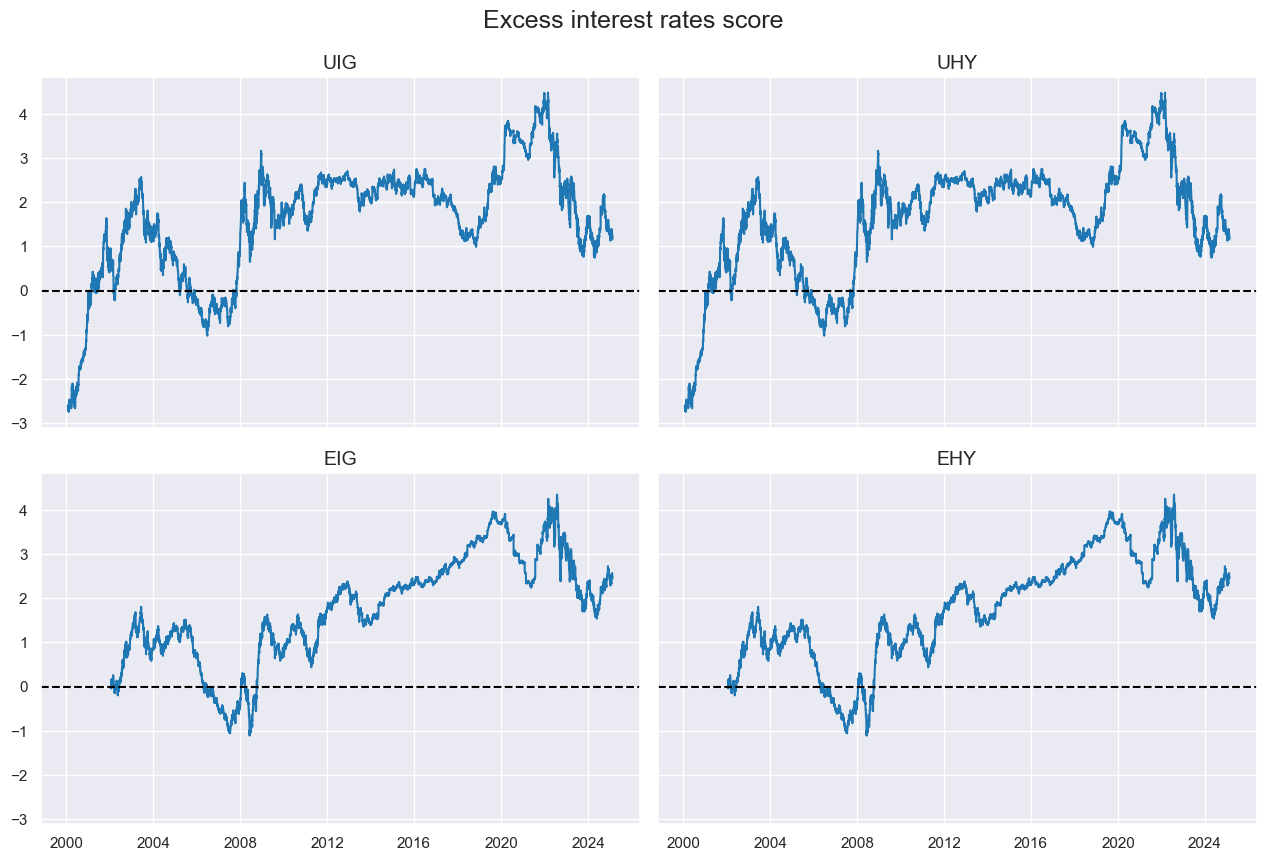

In [24]:
cidx = cids_cr
xcatx = ["XRATES_NEG"]

msp.view_timelines(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    title="Excess interest rates score",
    ncol=2,
    same_y=True,
    aspect=1.5,
)

#### Bank lending surveys

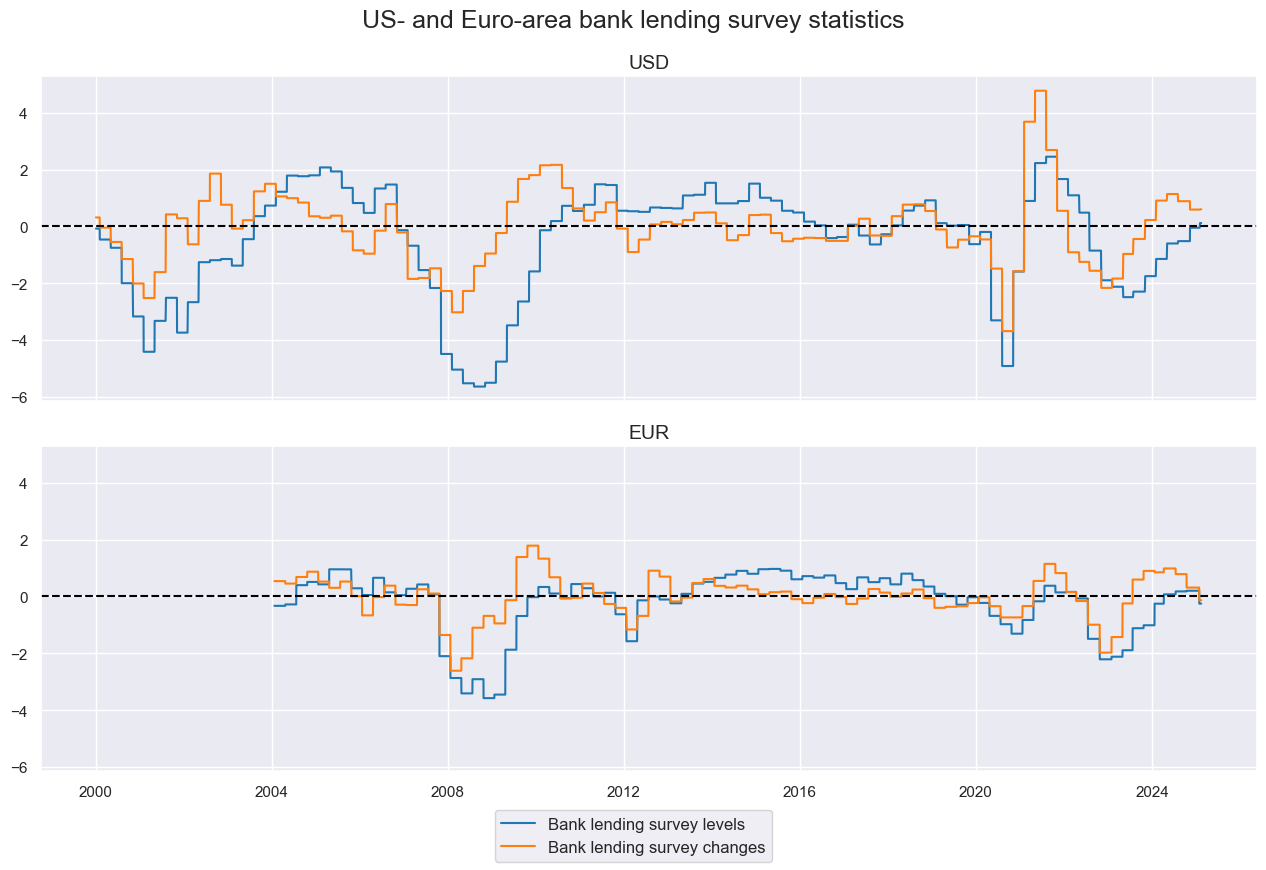

In [25]:
bls = ["BLSCSCORE_NSA", "BLSCSCORE_NSA_D2Q2QL2"]

cidx = ["UIG", "EIG"]
xcatx = bls

msp.view_timelines(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    title="US- and Euro-area bank lending survey statistics",
    ncol=1,
    same_y=True,
    aspect=3,
    xcat_labels=["Bank lending survey levels", "Bank lending survey changes"],
    cid_labels=["USD", "EUR"],
)

In [26]:
# Composite bank lending supply score
cidx = cids_cr
xcatx = bls

dfa = msp.linear_composite(df=dfx, xcats=xcatx, cids=cids_cr, new_xcat="BLSCOND")
dfx = msm.update_df(dfx, dfa)

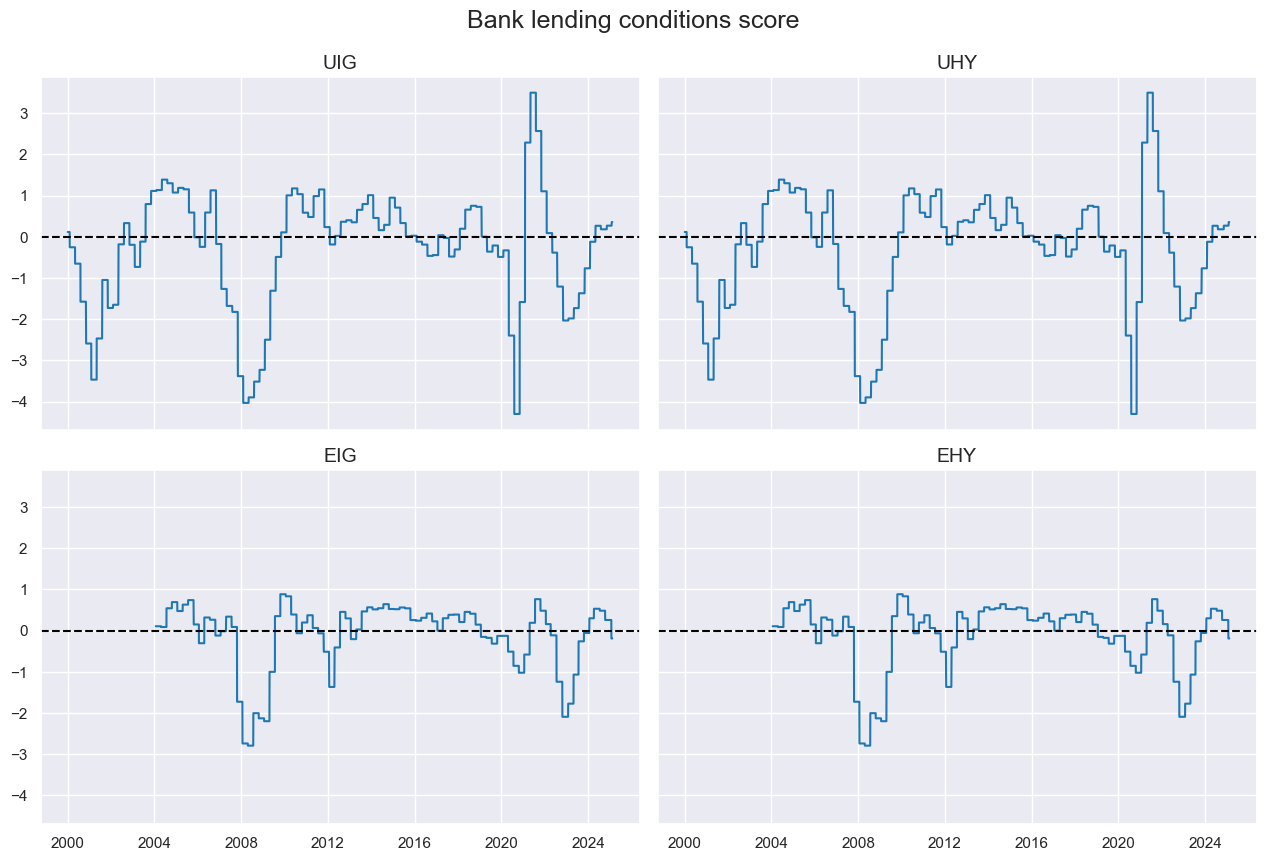

In [27]:
cidx = cids_cr
xcatx = ["BLSCOND"]

msp.view_timelines(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    title="Bank lending conditions score",
    ncol=2,
    same_y=True,
    aspect=1.5,
)

#### Private credit growth

In [28]:
# Credit acceleration category

cidx = cids_cr
calcs = []

calcs.append("PCG_DOYA = PCREDITBN_SJA_P1M1ML12_D1M1ML12")
calcs.append("XPCG = PCREDITBN_SJA_P1M1ML12 - INFTEFF_NSA - RGDP_SA_P1Q1QL4_20QMA")

dfa = msp.panel_calculator(df=dfx, calcs=calcs, cids=cidx)
dfx = msm.update_df(dfx, dfa)

xpcgd = ["XPCG", "PCG_DOYA"]

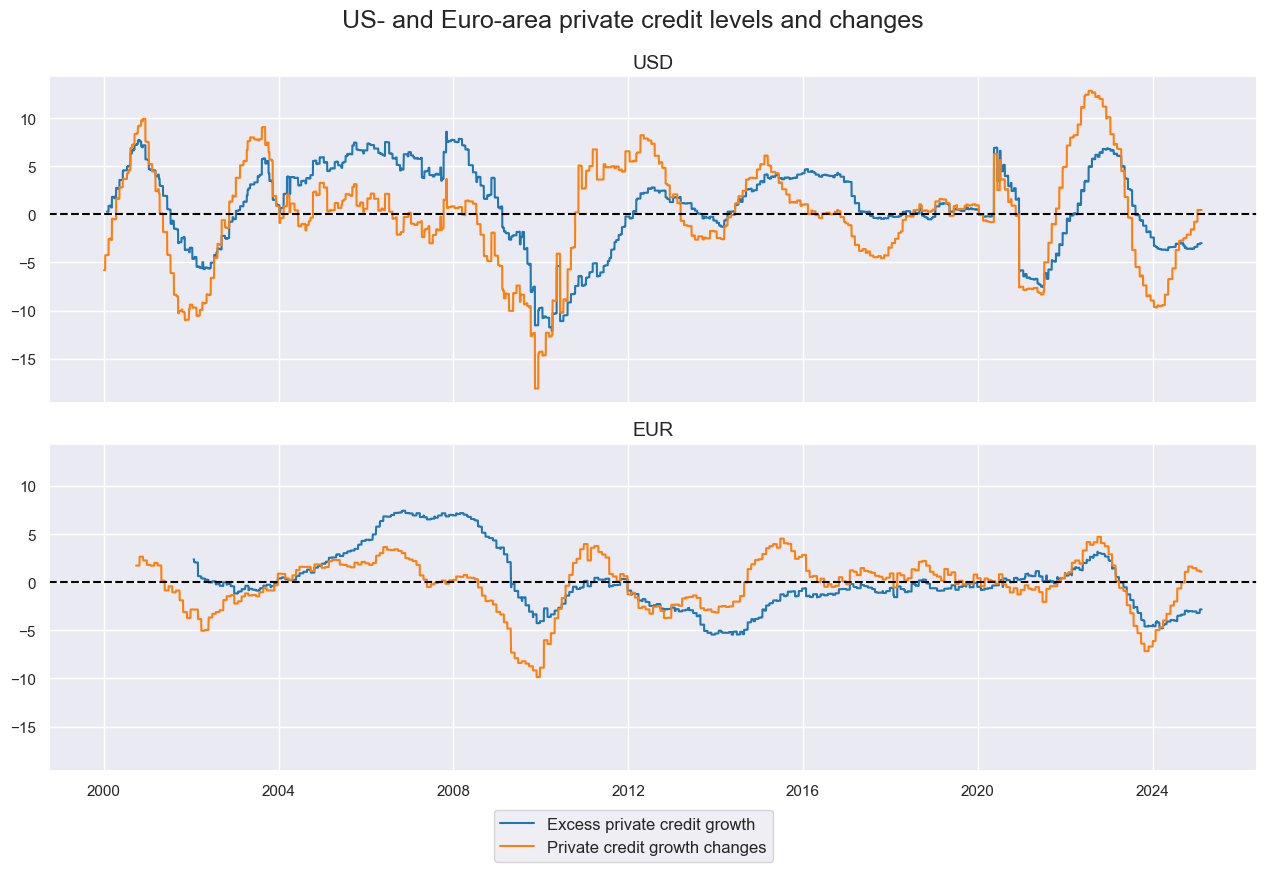

In [29]:
cidx = ["UIG", "EIG"]
xcatx = xpcgd

msp.view_timelines(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    title="US- and Euro-area private credit levels and changes",
    ncol=1,
    same_y=True,
    aspect=3,
    xcat_labels=["Excess private credit growth", "Private credit growth changes"],
    cid_labels=["USD", "EUR"],
)

In [30]:
# Single credit expansion category
cidx = cids_cr
xcatx = xpcgd

dfa = msp.linear_composite(df=dfx, xcats=xcatx, cids=cids_cr, new_xcat="XPCREDIT")
dfx = msm.update_df(dfx, dfa)

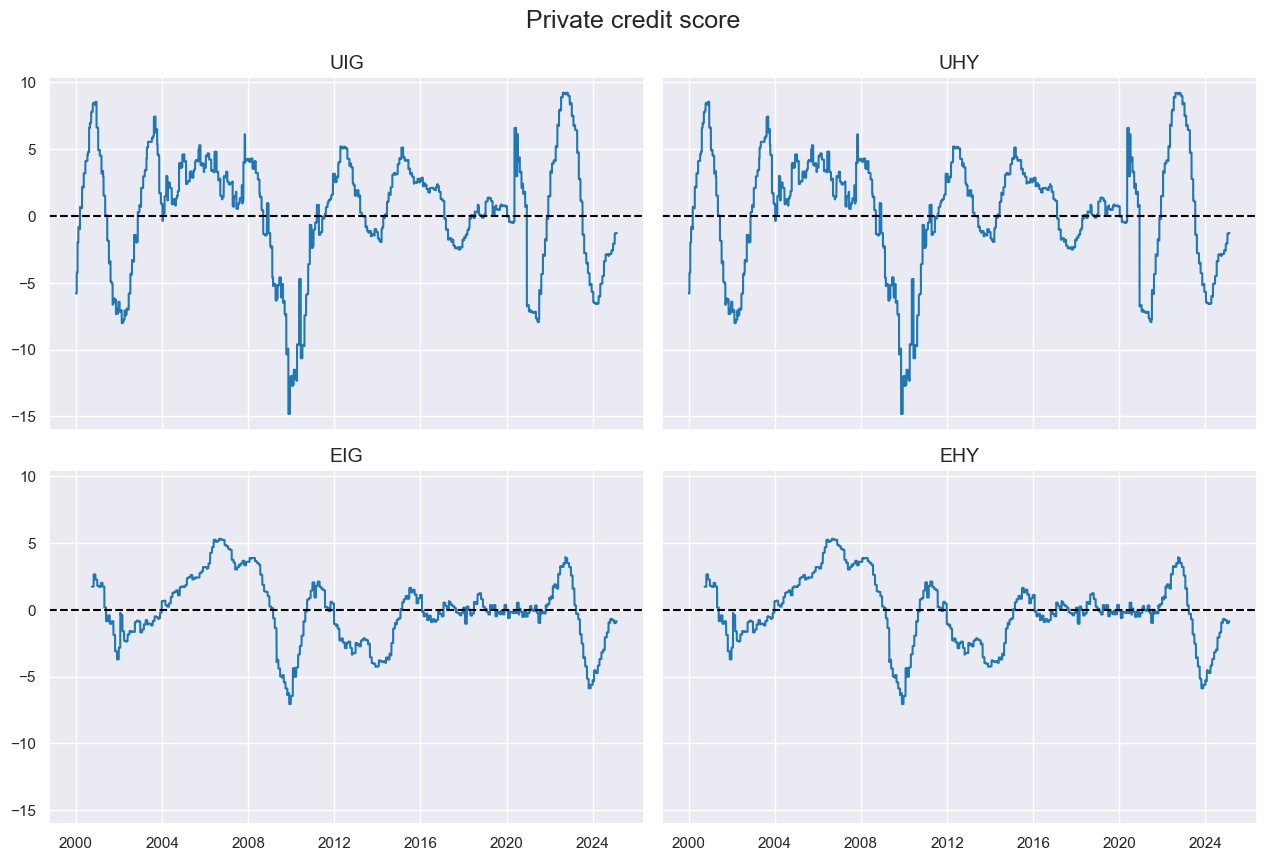

In [31]:
cidx = cids_cr
xcatx = ["XPCREDIT"]

msp.view_timelines(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    title="Private credit score",
    ncol=2,
    same_y=True,
    aspect=1.5,
)

#### CDS spread widening

In [32]:
# Credit acceleration category (temp proxy)

cidx = cids_cr
calcs = []

calcs.append("CSPREAD_1MMA = CRCRY_NSA.rolling(21).mean()")
calcs.append("CSPREAD_3MMA = CRCRY_NSA.rolling(21*3).mean()")
calcs.append("CSPREAD_6MMA = CRCRY_NSA.rolling(21*6).mean()")
calcs.append("CSPREAD_3MMA_L1M = CSPREAD_3MMA.shift(21)")
calcs.append("CSPREAD_6MMA_L3M = CSPREAD_6MMA.shift(21*3)")
calcs.append(
    "CSPREAD_P1Mv3M_NEG = - ( CSPREAD_1MMA - CSPREAD_3MMA_L1M ) / CSPREAD_3MMA_L1M"
)
calcs.append(
    "CSPREAD_P3Mv6M_NEG = - ( CSPREAD_3MMA - CSPREAD_6MMA_L3M ) / CSPREAD_6MMA_L3M"
)

dfa = msp.panel_calculator(df=dfx, calcs=calcs, cids=cidx)
dfx = msm.update_df(dfx, dfa)

csp = ["CSPREAD_P1Mv3M_NEG", "CSPREAD_P3Mv6M_NEG"]

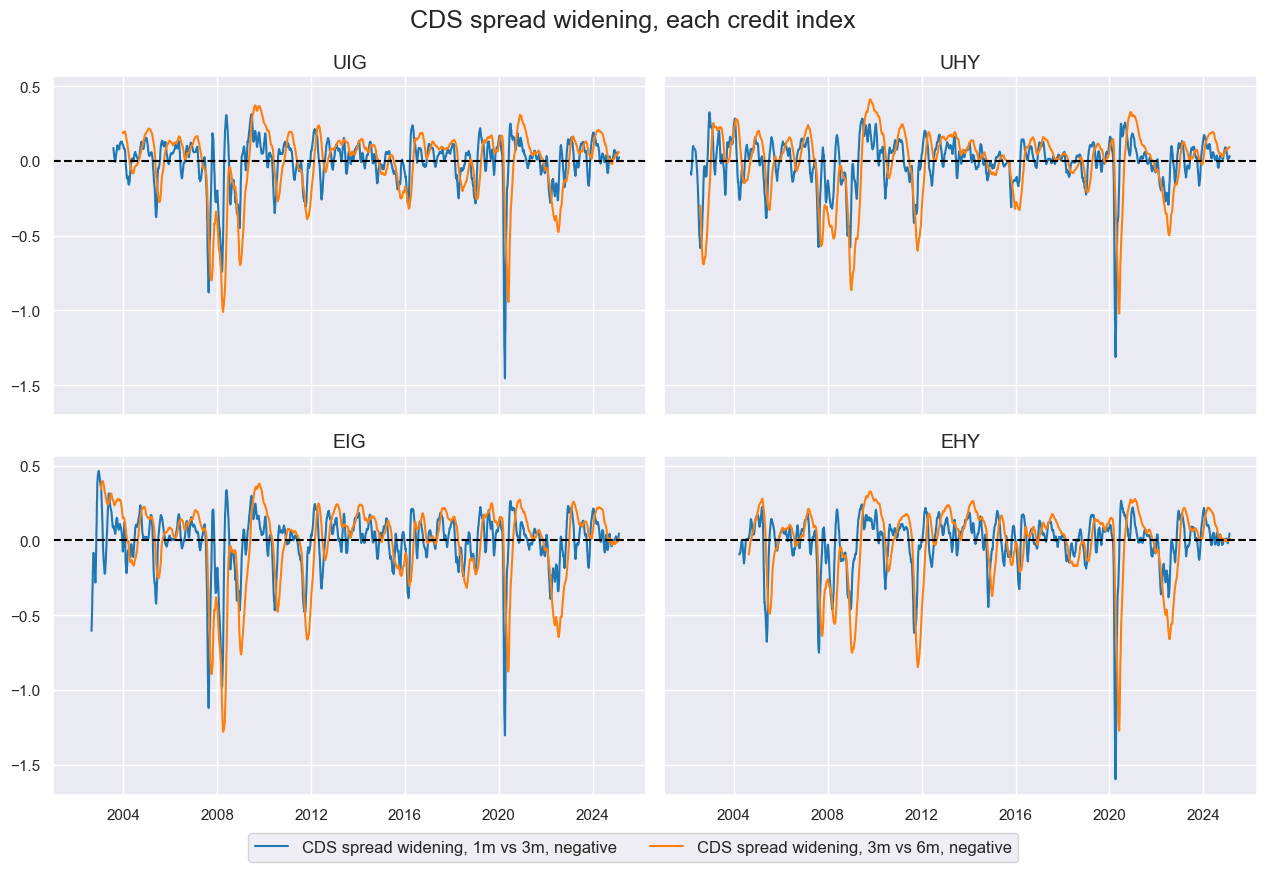

In [33]:
cidx = cids_cr
xcatx = csp

msp.view_timelines(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    title="CDS spread widening, each credit index",
    ncol=2,
    same_y=True,
    aspect=1.5,
    xcat_labels=[
        "CDS spread widening, 1m vs 3m, negative",
        "CDS spread widening, 3m vs 6m, negative",
    ],
)

In [34]:
# Single credit expansion category
cidx = cids_cr
xcatx = csp

dfa = msp.linear_composite(
    df=dfx, xcats=xcatx, cids=cids_cr, new_xcat="CSPRWIDE_NEG", start="2002-01-01"
)
dfx = msm.update_df(dfx, dfa)

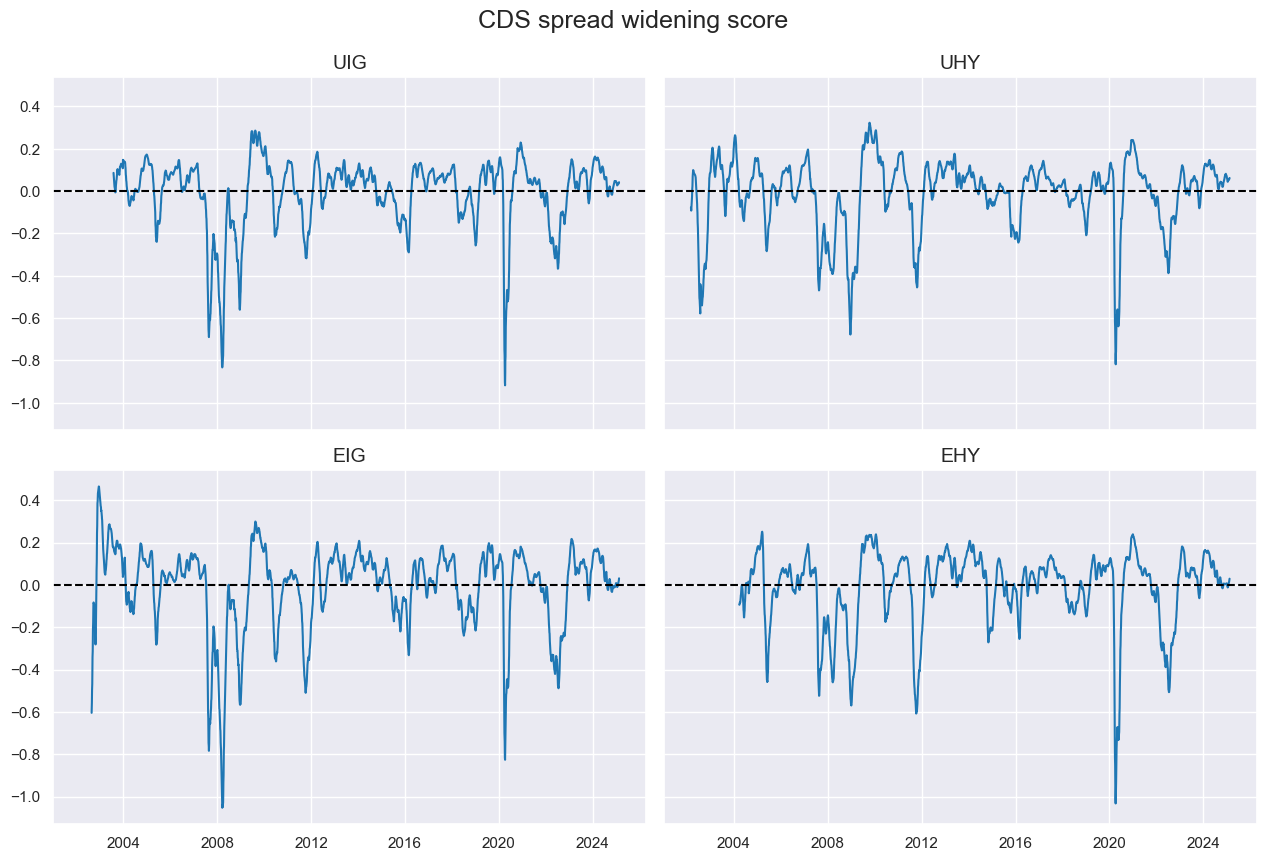

In [35]:
cidx = cids_cr
xcatx = ["CSPRWIDE_NEG"]

msp.view_timelines(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    title="CDS spread widening score",
    ncol=2,
    same_y=True,
    aspect=1.5,
)

### Transformations and visualizations

In [36]:
factors = ["BCONFCHG", "XHPI", "XRATES_NEG", "BLSCOND", "XPCREDIT", "CSPRWIDE_NEG"]

#### Normalization

In [37]:
# Zn-scores

xcatx = factors
cidx = cids_cr

dfa = pd.DataFrame(columns=list(dfx.columns))

for xc in xcatx:
    dfaa = msp.make_zn_scores(
        dfx,
        xcat=xc,
        cids=cidx,
        sequential=True,
        min_obs=261 * 3,
        neutral="zero",
        pan_weight=0,
        thresh=3,
        postfix="_ZN",
        est_freq="m",
    )
    dfa = msm.update_df(dfa, dfaa)

dfx = msm.update_df(dfx, dfa)

# Modified factor dictionary

factorz = [xcat + "_ZN" for xcat in factors]

#### Visual checks

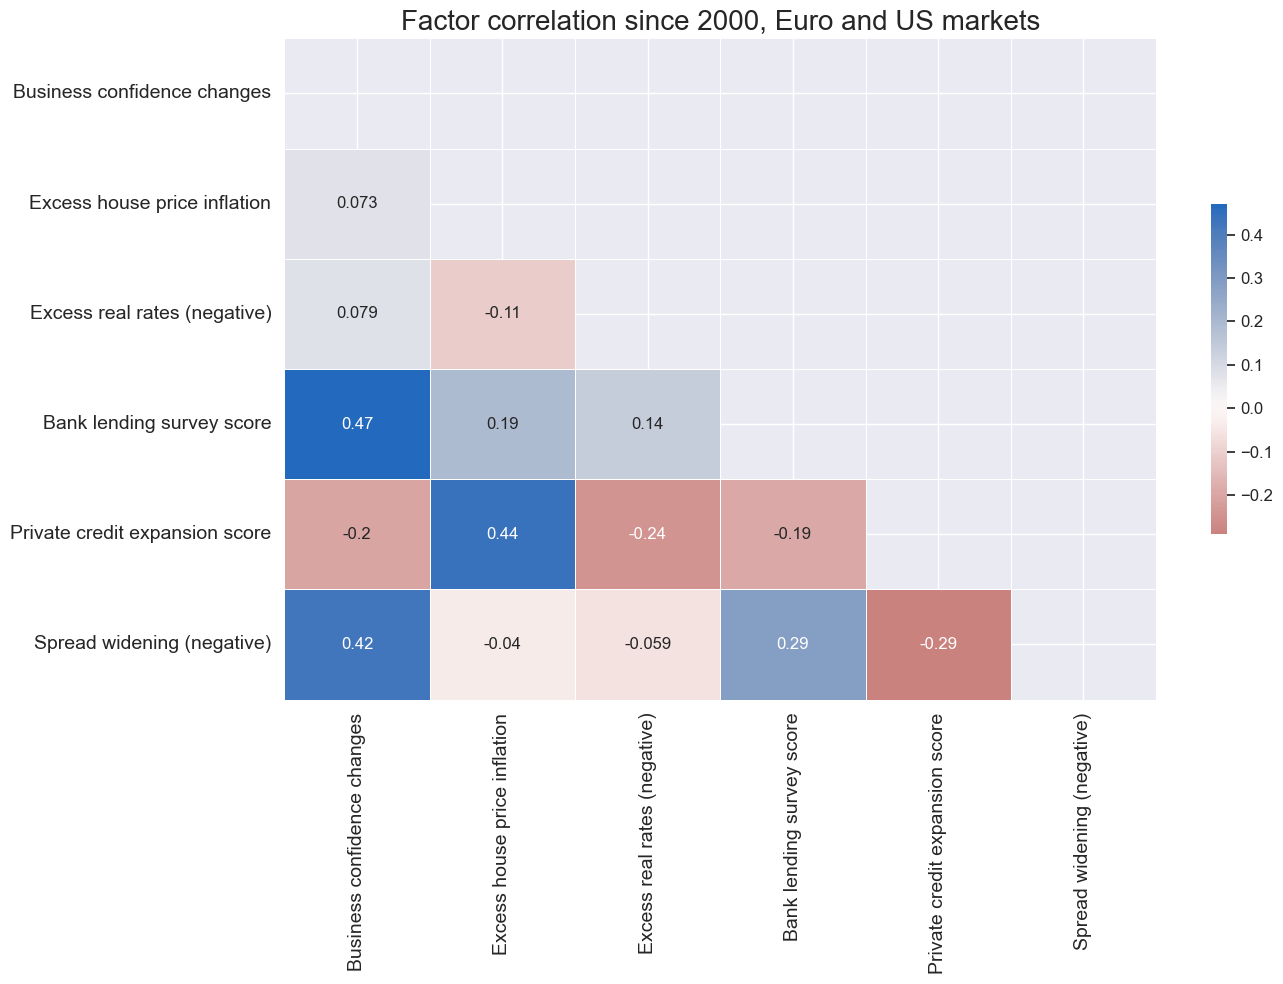

In [38]:
xcatx = factorz
cidx = cids_cr

sdate = "2000-01-01"

renaming_dict = {
    "BCONFCHG_ZN": "Business confidence changes",
    "XHPI_ZN": "Excess house price inflation",
    "XRATES_NEG_ZN": "Excess real rates (negative)",
    "BLSCOND_ZN": "Bank lending survey score",
    "XPCREDIT_ZN": "Private credit expansion score",
    "CSPRWIDE_NEG_ZN": "Spread widening (negative)",
}

msp.correl_matrix(
    dfx,
    xcat_labels=renaming_dict,
    xcats=xcatx,
    cids=cidx,
    start=sdate,
    freq="M",
    title="Factor correlation since 2000, Euro and US markets",
    size=(14, 10),
    annot=True,
)

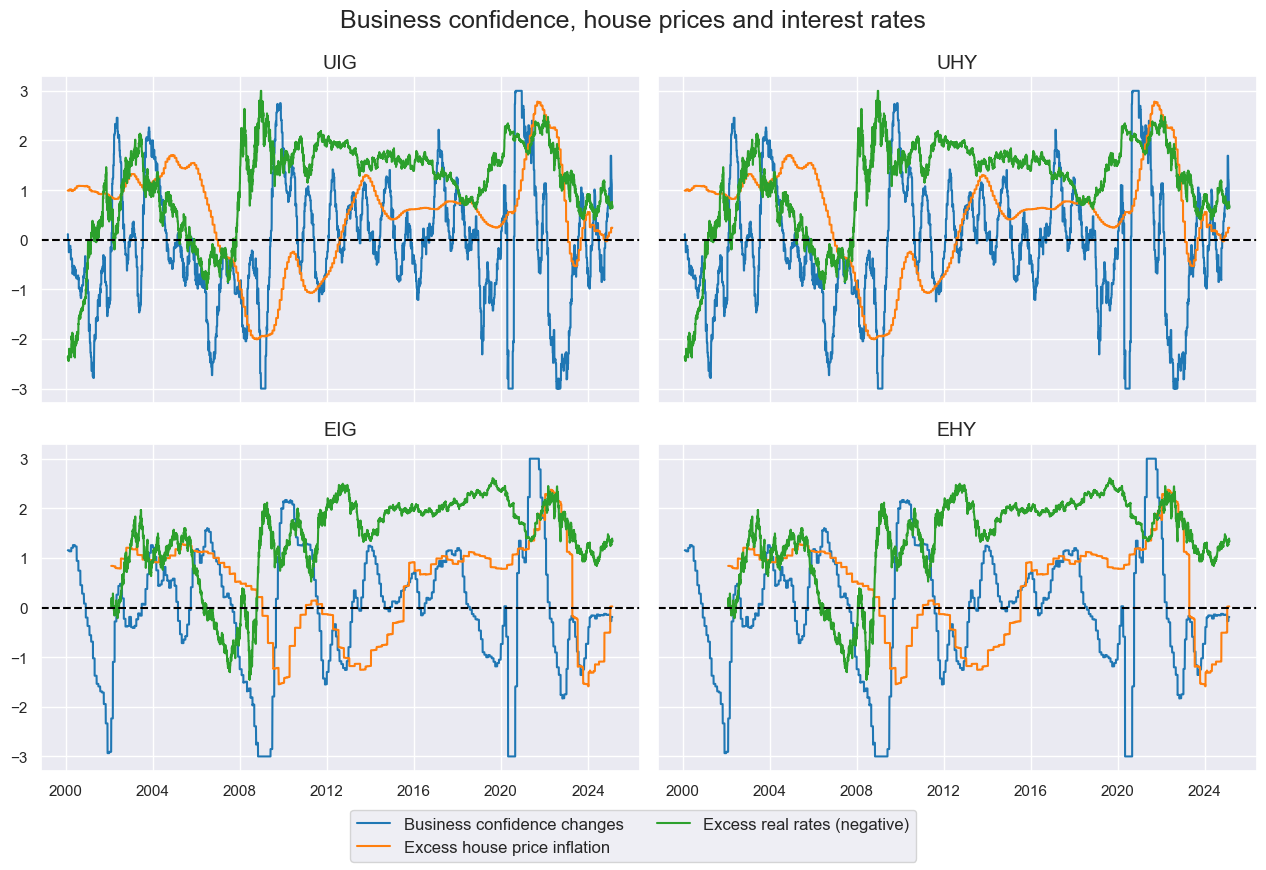

In [39]:
cidx = cids_cr
xcatx = factorz[:3]

msp.view_timelines(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    title="Business confidence, house prices and interest rates",
    xcat_labels=list(renaming_dict.values())[:3],
    ncol=2,
    same_y=True,
    aspect=1.5,
)

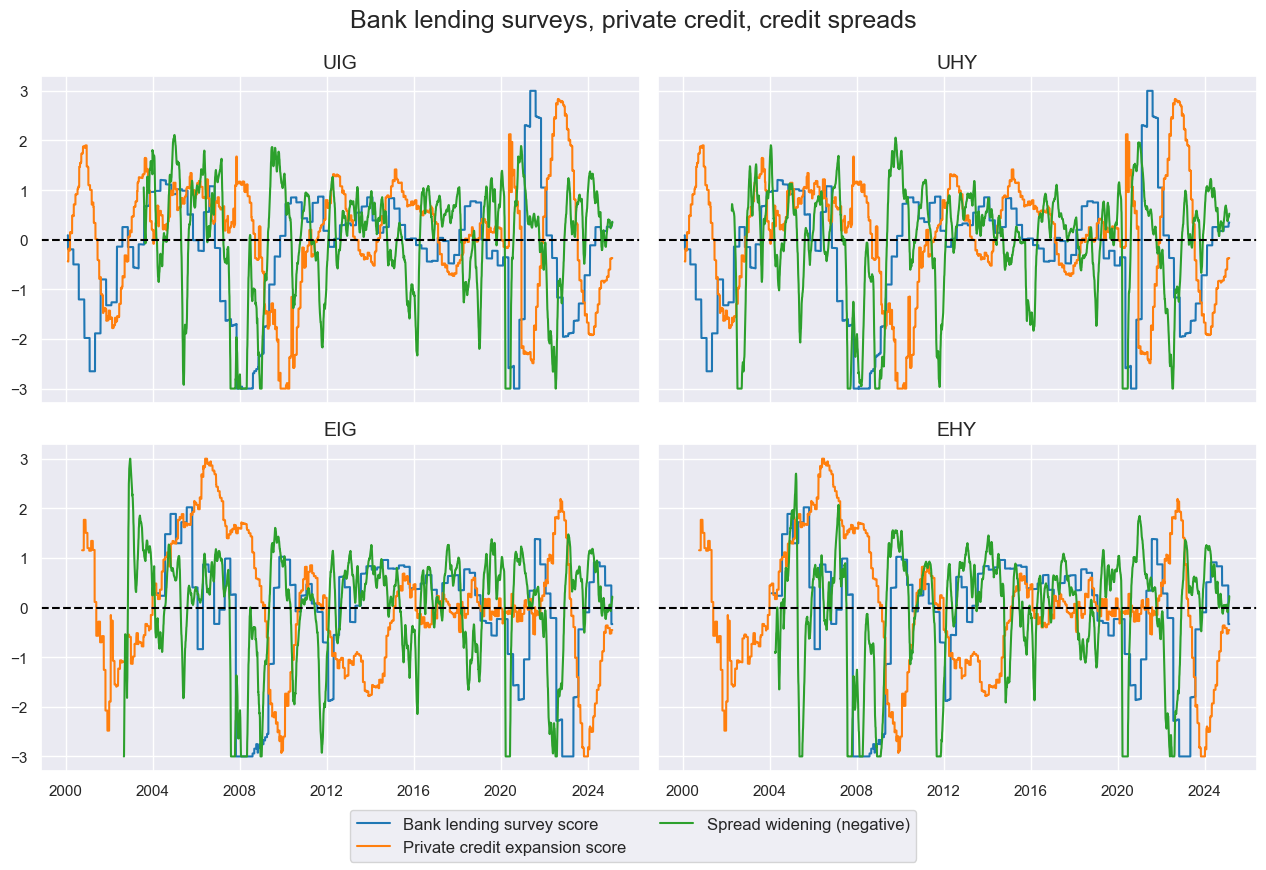

In [40]:
cidx = cids_cr
xcatx = factorz[3:]

msp.view_timelines(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    title="Bank lending surveys, private credit, credit spreads",
    xcat_labels=list(renaming_dict.values())[3:6],
    ncol=2,
    same_y=True,
    aspect=1.5,
)

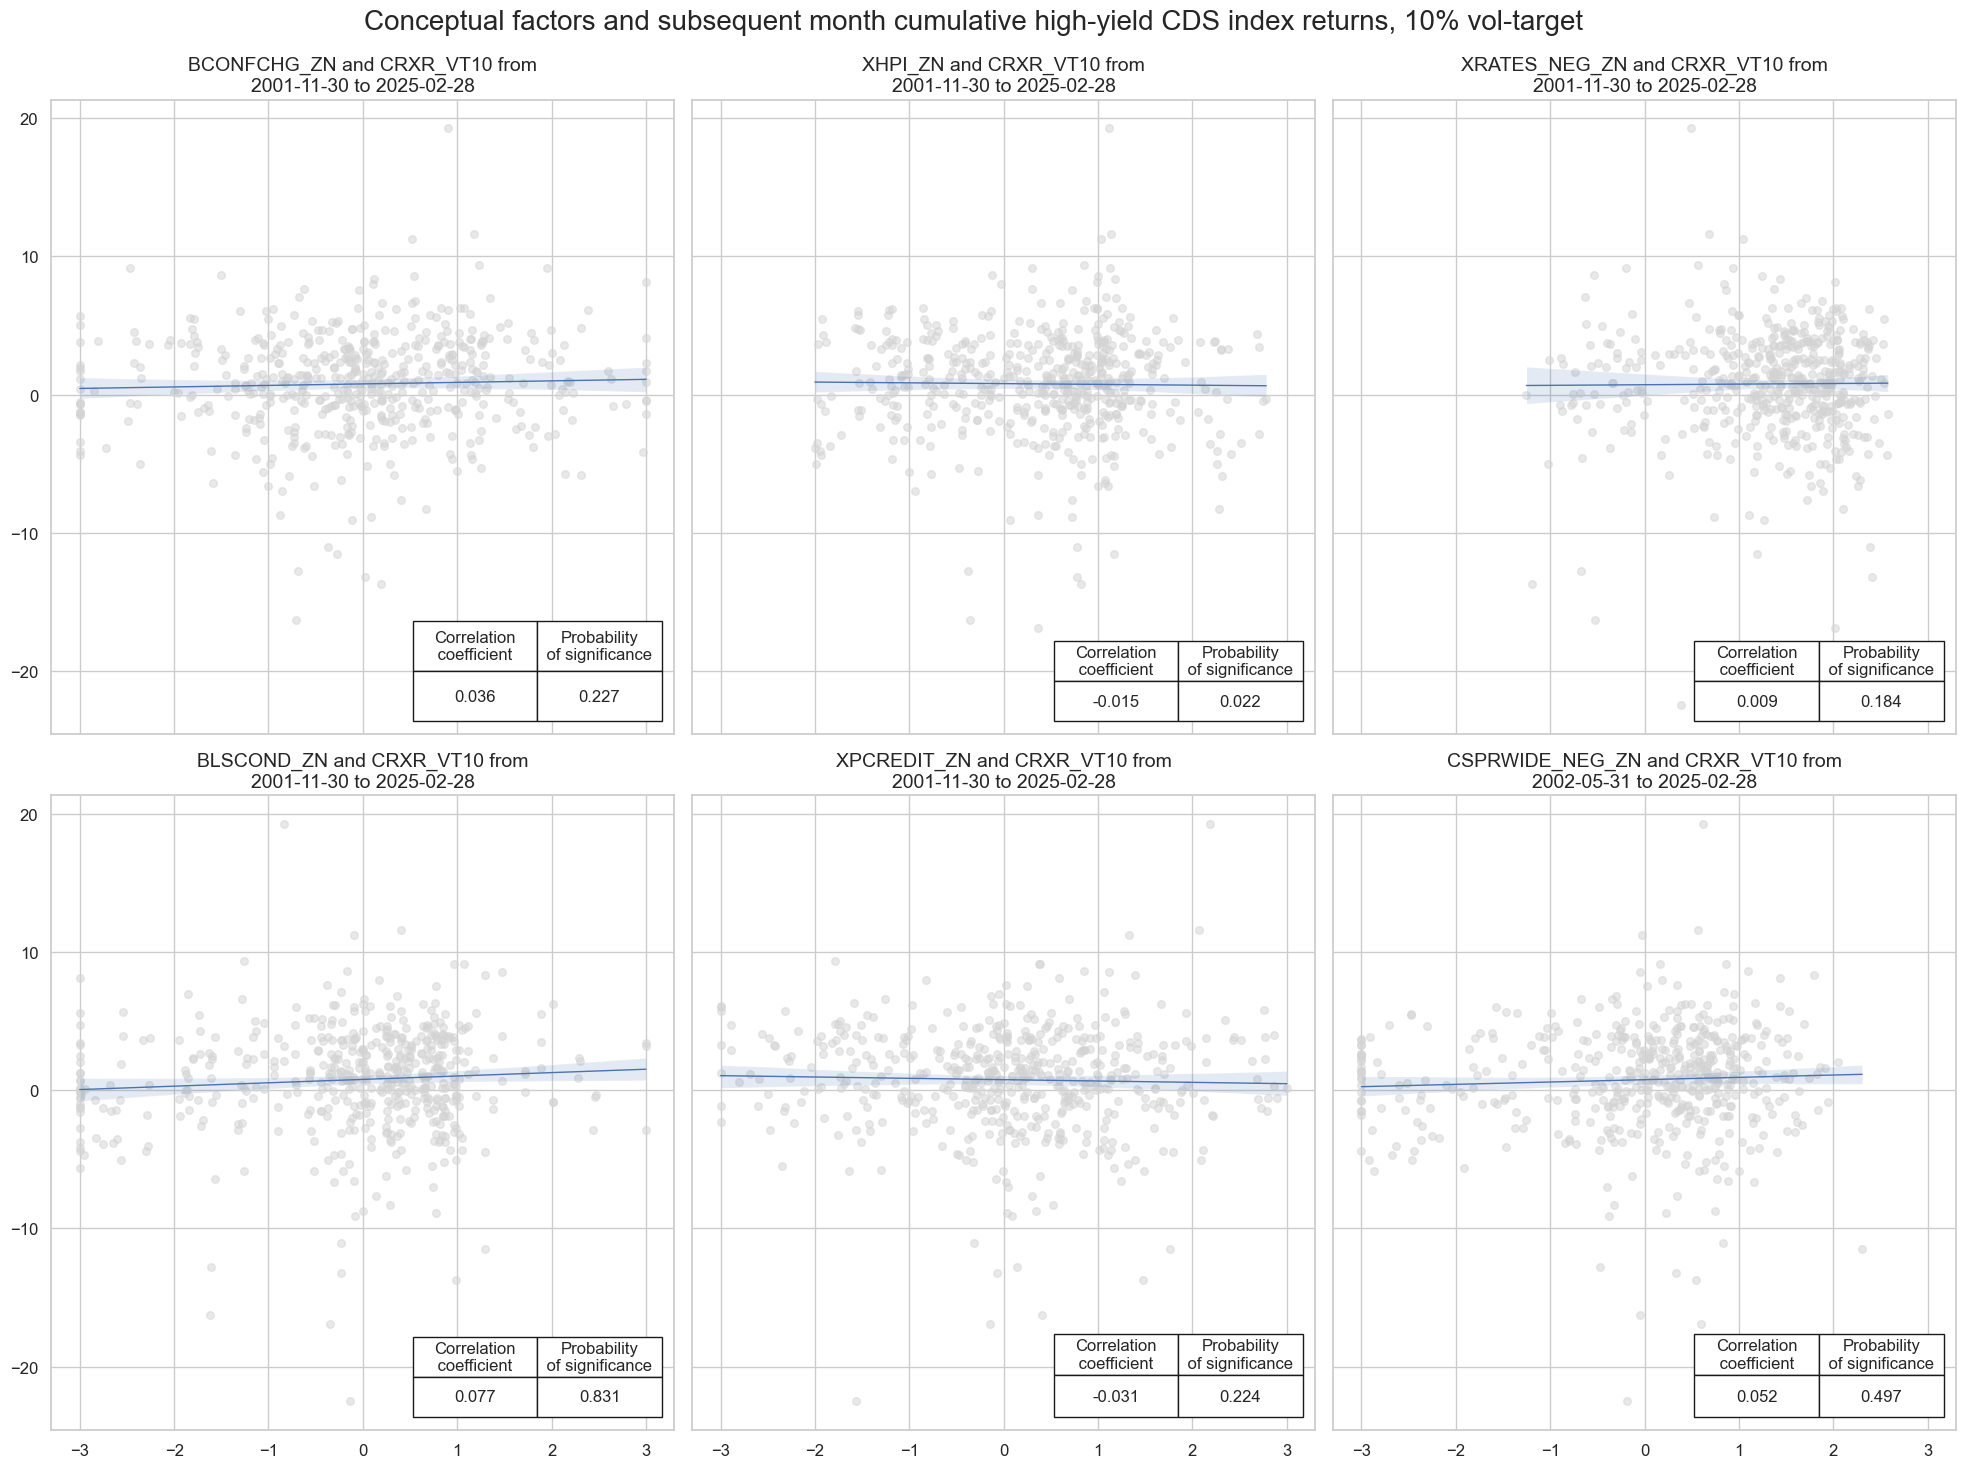

In [41]:
crs = []

for xcat in factorz:
    cr = msp.CategoryRelations(
        df=dfx,
        xcats=[xcat, "CRXR_VT10"],
        cids=cids_hy,
        freq="M",
        lag=1,
        xcat_aggs=["last", "sum"],
        slip=1,
    )
    crs.append(cr)


msv.multiple_reg_scatter(
    cat_rels=crs,
    ncol=3,
    nrow=2,
    coef_box="lower right",
    prob_est="map",
    title="Conceptual factors and subsequent month cumulative high-yield CDS index returns, 10% vol-target",
)

## Target return checks

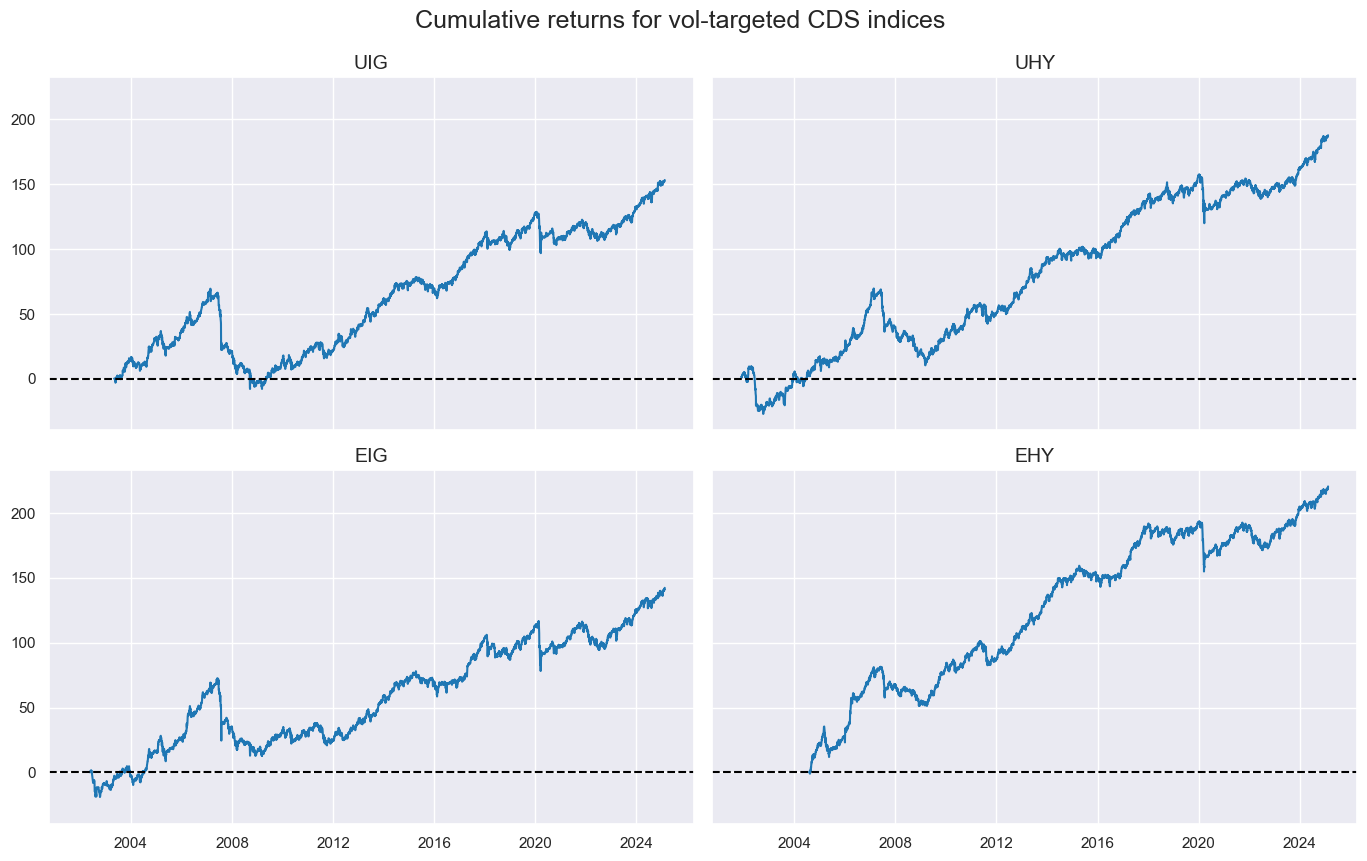

In [42]:
xcatx = ["CRXR_VT10"]
cidx = cids_cr

msp.view_timelines(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    cumsum=True,
    title="Cumulative returns for vol-targeted CDS indices ",
    ncol=2,
)

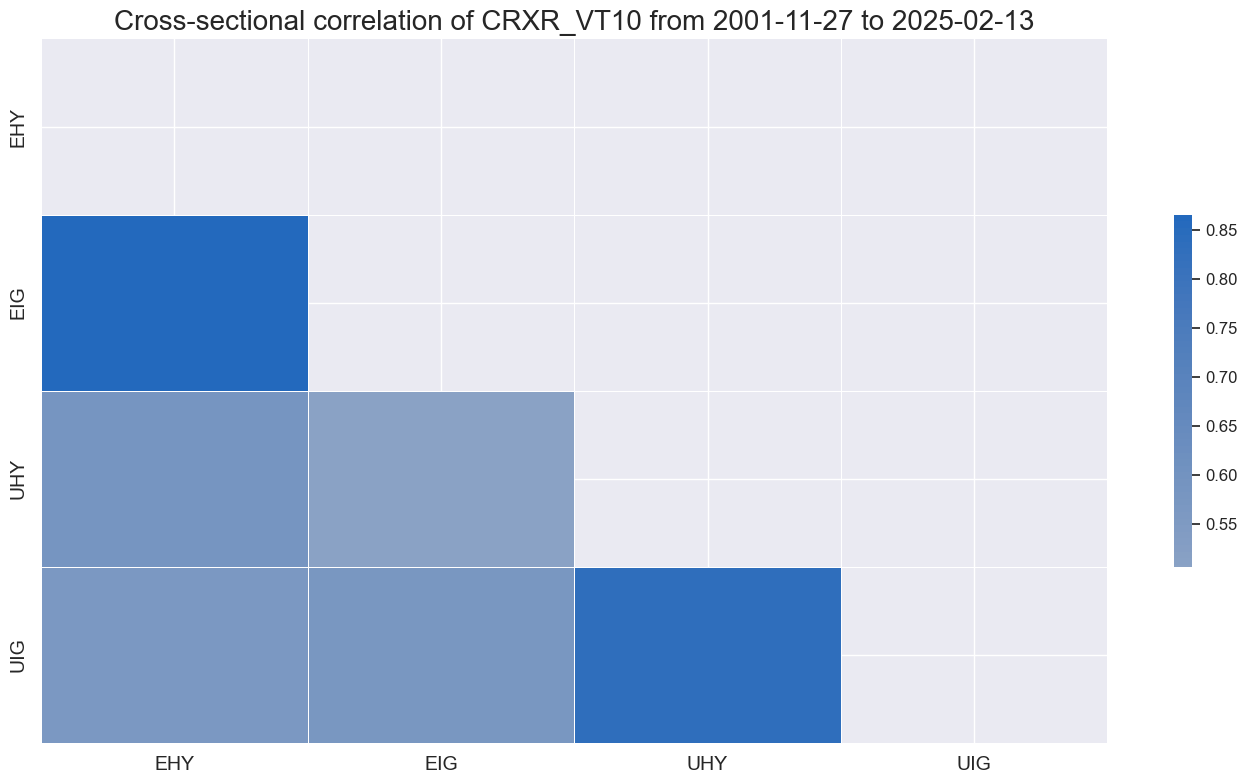

In [43]:
xcatx = ["CRXR_VT10"]
cidx = cids_cr

msp.correl_matrix(df=dfx, xcats=xcatx, cids=cidx, cluster=True)

## Preparations for statistical learning

### Convert data to scikit-learn format (redundant)

In [44]:
cidx = cids_cr
targ = "CRXR_VT10"
xcatx = factorz + [targ]

# Downsample from daily to monthly frequency (features as last and target as sum)
dfw = msm.categories_df(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
)

# Drop rows with missing values and assign features and target
dfw.dropna(inplace=True)
X_cr = dfw.iloc[:, :-1]
y_cr = dfw.iloc[:, -1]

### Define cross-validation dynamics

Visualize back test dynamics (with a one year forward window for visualization purposes).

* The first set comprises the first 2 years of the panel. 
* A one month forward forecast is made.

Noting longer training times for random forests, that particular model is retrained every quarter. 

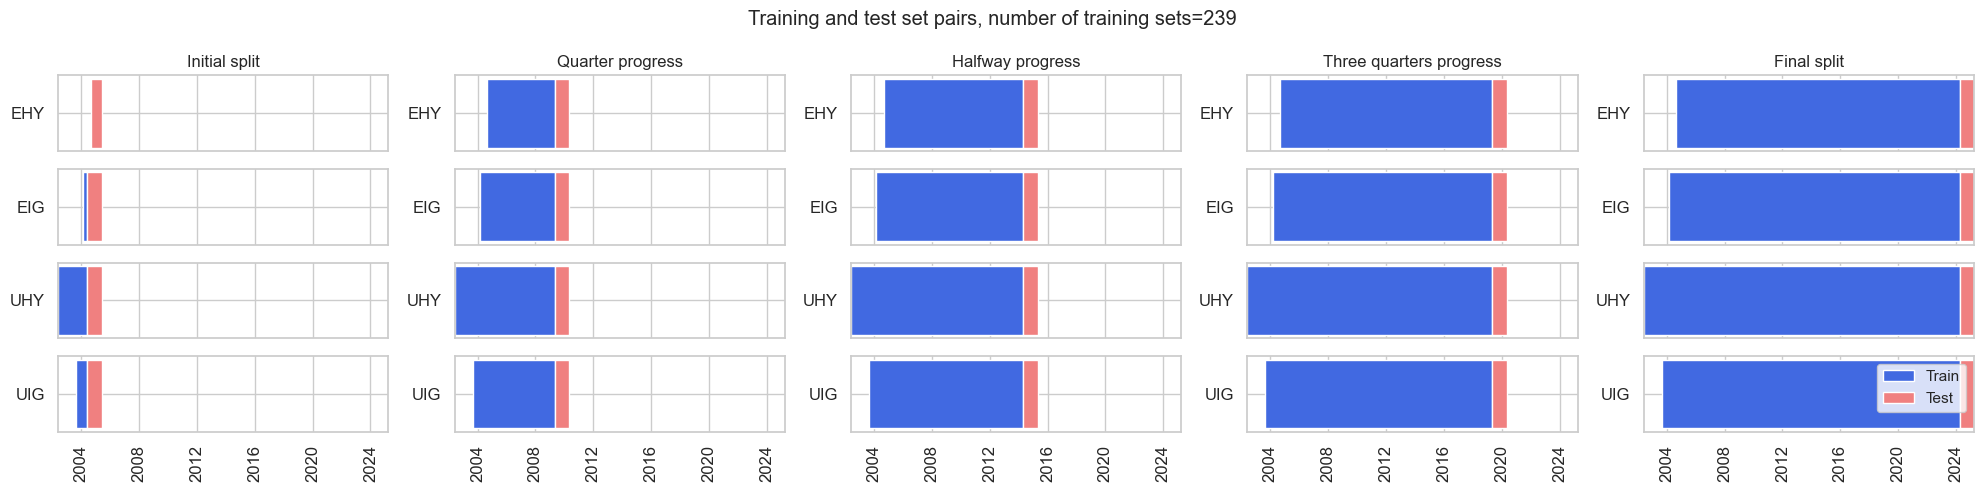

In [45]:
# Initial split dynamics
min_cids = 1
min_periods = 12 * 2
test_size = 1

# Visualize back test pipeline
msl.ExpandingIncrementPanelSplit(
    train_intervals=test_size,
    test_size=12,
    min_cids=min_cids,
    min_periods=min_periods,
).visualise_splits(X_cr, y_cr)

In [46]:
# Cross-validation dynamics
splitters = {
    "Expanding": msl.ExpandingKFoldPanelSplit(4),
    "Rolling": msl.RollingKFoldPanelSplit(4),
}

split_functions = None
scorers = {"BAC": make_scorer(balanced_accuracy_score)}
cv_summary = "median"

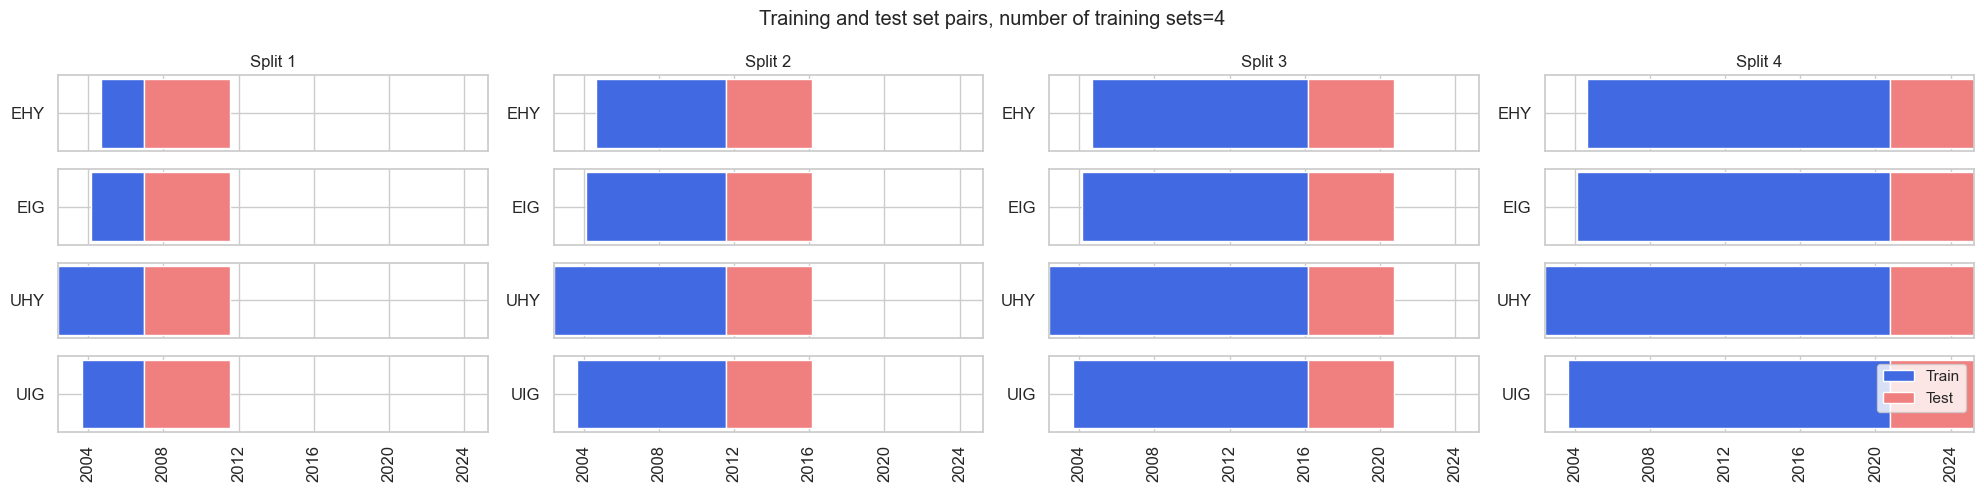

In [47]:
splitters["Expanding"].visualise_splits(X_cr, y_cr)

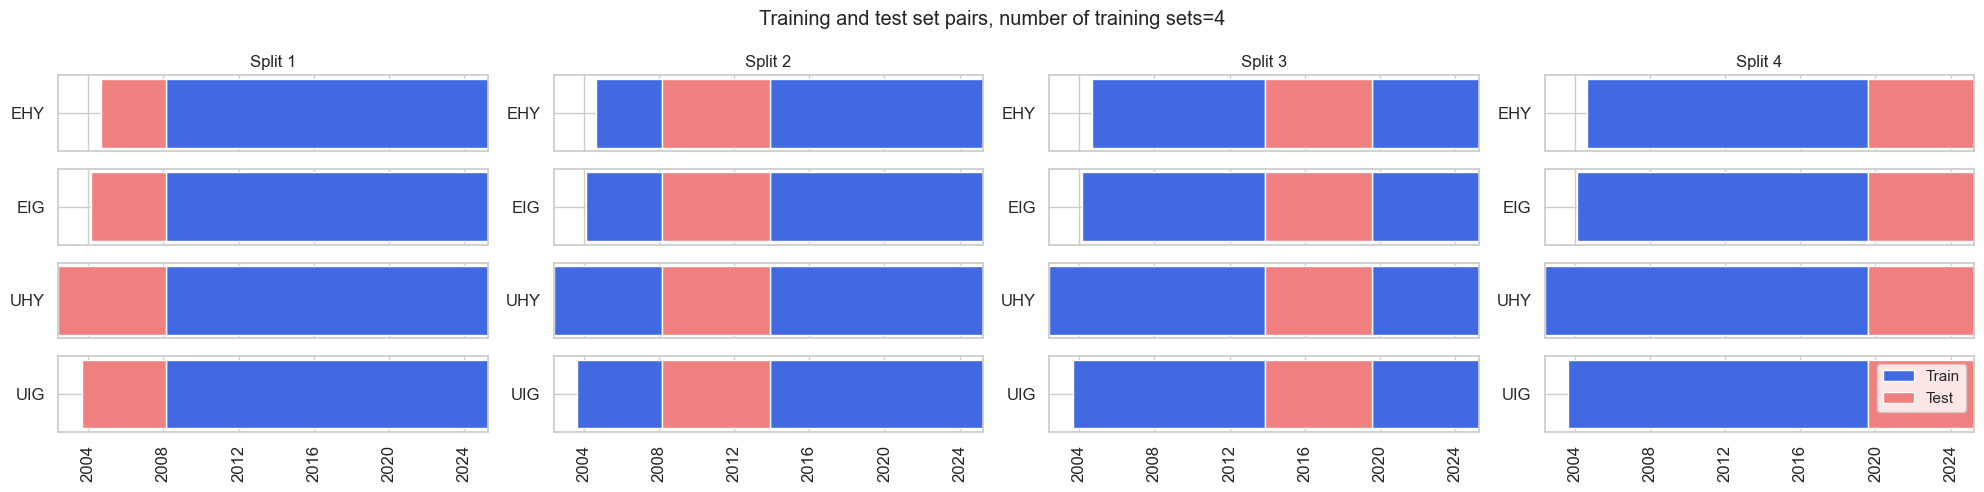

In [48]:
splitters["Rolling"].visualise_splits(X_cr, y_cr)

## Signal generation

### Pooled panel models

#### Naive Bayes

  0%|          | 0/250 [00:00<?, ?it/s]

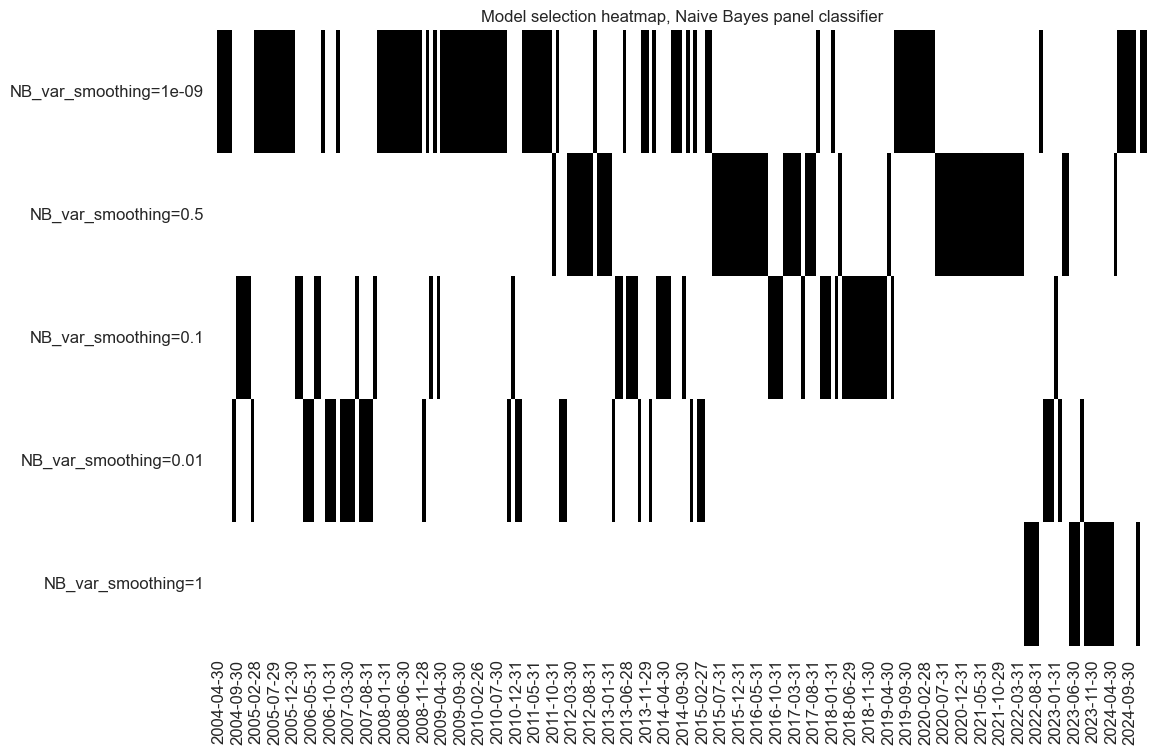

In [49]:
so_nb = msl.SignalOptimizer(
    df=dfx,
    xcats=factorz + ["CRXR_VT10"],
    cids=cids_cr,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    generate_labels=lambda x: 1 if x >= 0 else -1,
)

so_nb.calculate_predictions(
    name="NB",
    models={"NB": GaussianNB()},
    hyperparameters={
        "NB": {
            "var_smoothing": [1e-9, 1e-2, 1e-1, 5e-1, 1],
        },
    },
    scorers=scorers,
    inner_splitters=splitters,
    min_cids=min_cids,
    min_periods=min_periods,
    test_size=test_size,
    n_jobs_outer=-1,
    cv_summary=cv_summary,
    split_functions=split_functions,
)

so_nb.models_heatmap(
    "NB", title="Model selection heatmap, Naive Bayes panel classifier"
)

dfa = so_nb.get_optimized_signals("NB")
dfx = msm.update_df(dfx, dfa)

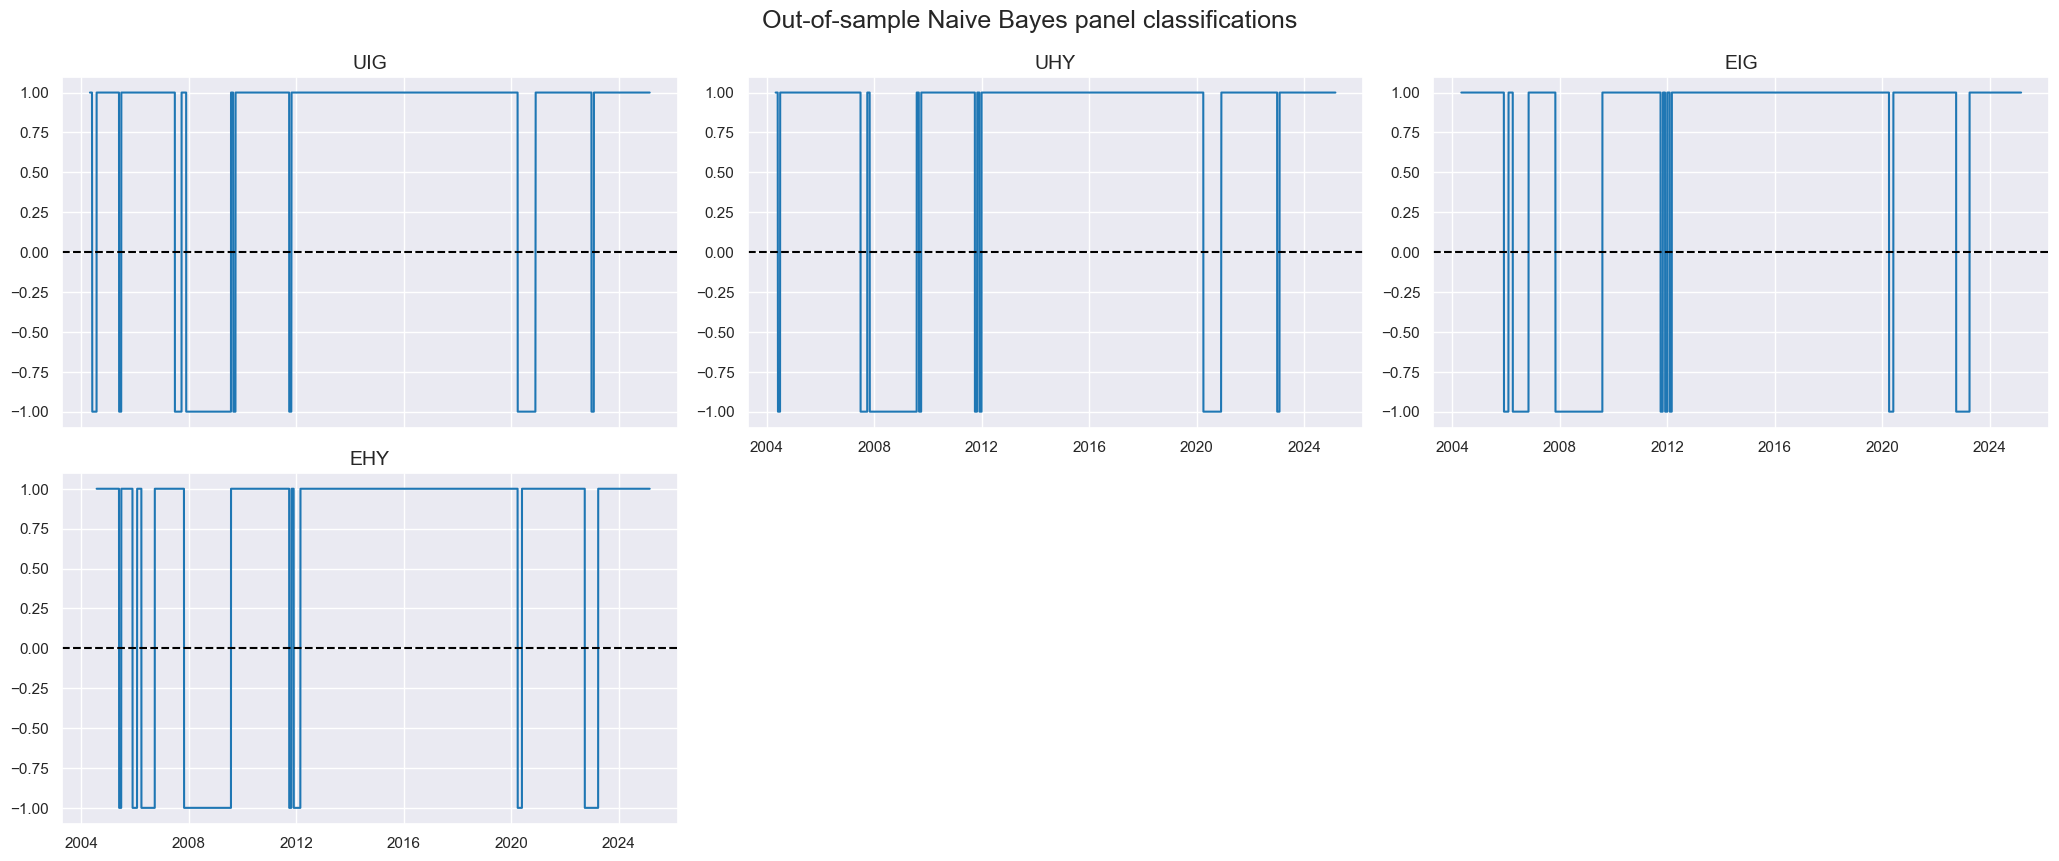

In [50]:
msp.view_timelines(
    df=dfx,
    xcats=["NB"],
    cids=cids_cr,
    title="Out-of-sample Naive Bayes panel classifications",
    same_y=False,
)

#### Logistic regression

  0%|          | 0/250 [00:00<?, ?it/s]

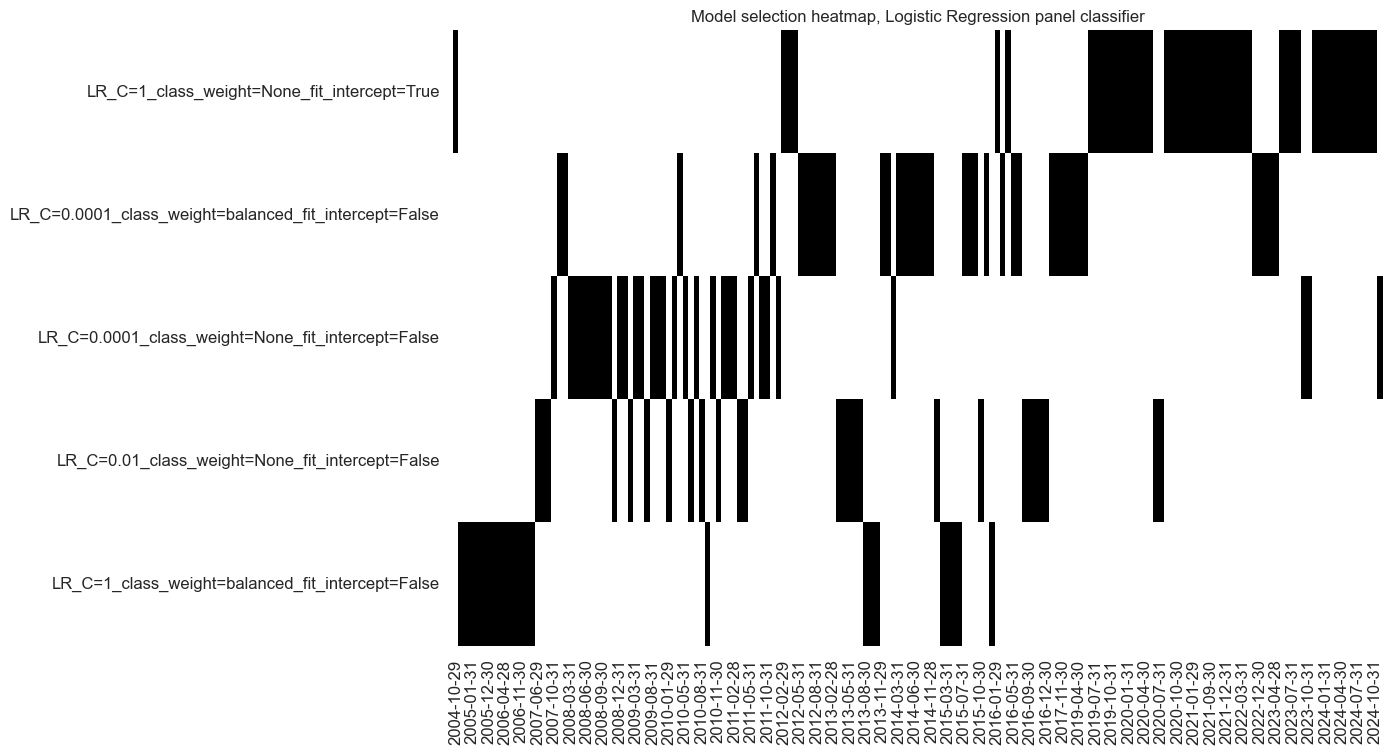

In [51]:
so_lr = msl.SignalOptimizer(
    df=dfx,
    xcats=factorz + ["CRXR_VT10"],
    cids=cids_cr,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    generate_labels=lambda x: 1 if x >= 0 else -1,
)

so_lr.calculate_predictions(
    name="LR",
    models={
        "LR": LogisticRegression(random_state=42),
    },
    hyperparameters={
        "LR": {
            "class_weight": ["balanced", None],
            "C": [1, 1e-2, 1e-4, 1e-6, 1e-8],
            "fit_intercept": [True, False],
        },
    },
    scorers=scorers,
    inner_splitters=splitters,
    min_cids=min_cids,
    min_periods=min_periods,
    cv_summary=cv_summary,
    test_size=test_size,
    n_jobs_outer=-1,
    split_functions=split_functions,
)

so_lr.models_heatmap(
    "LR", title="Model selection heatmap, Logistic Regression panel classifier"
)

dfa = so_lr.get_optimized_signals("LR")
dfx = msm.update_df(dfx, dfa)

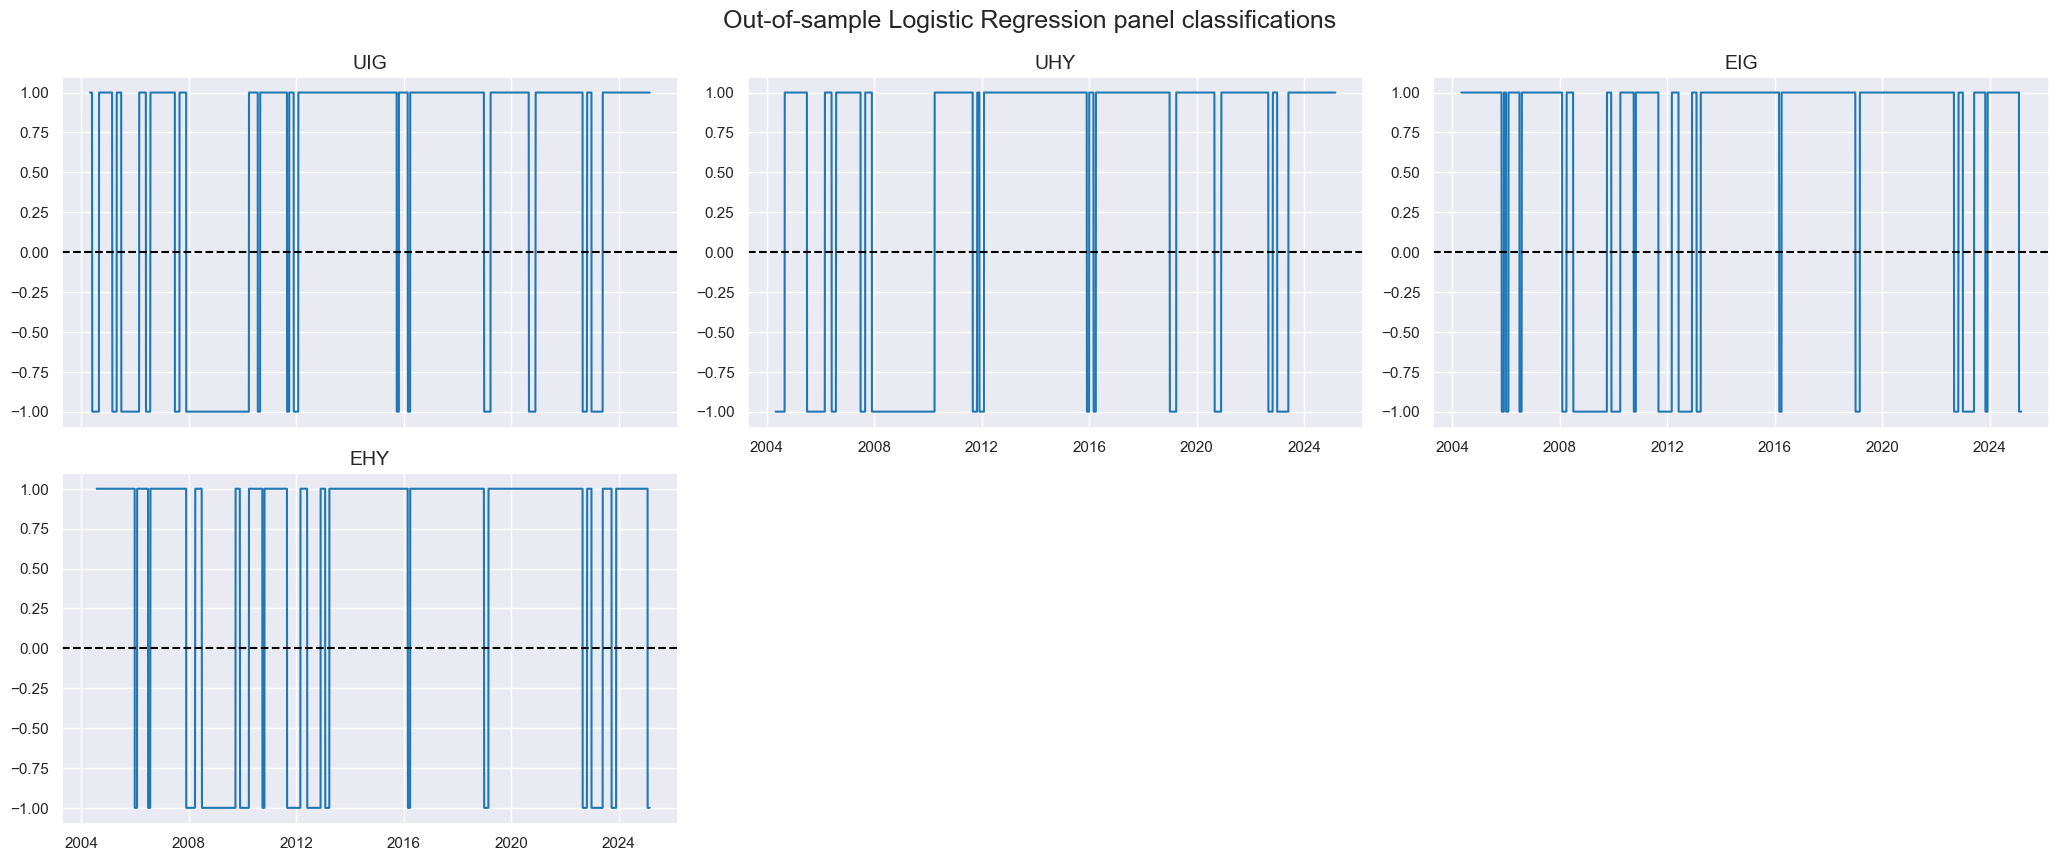

In [52]:
msp.view_timelines(
    df=dfx,
    xcats=["LR"],
    cids=cids_cr,
    title="Out-of-sample Logistic Regression panel classifications",
    same_y=False,
)

#### K Nearest Neighbors

  0%|          | 0/250 [00:00<?, ?it/s]

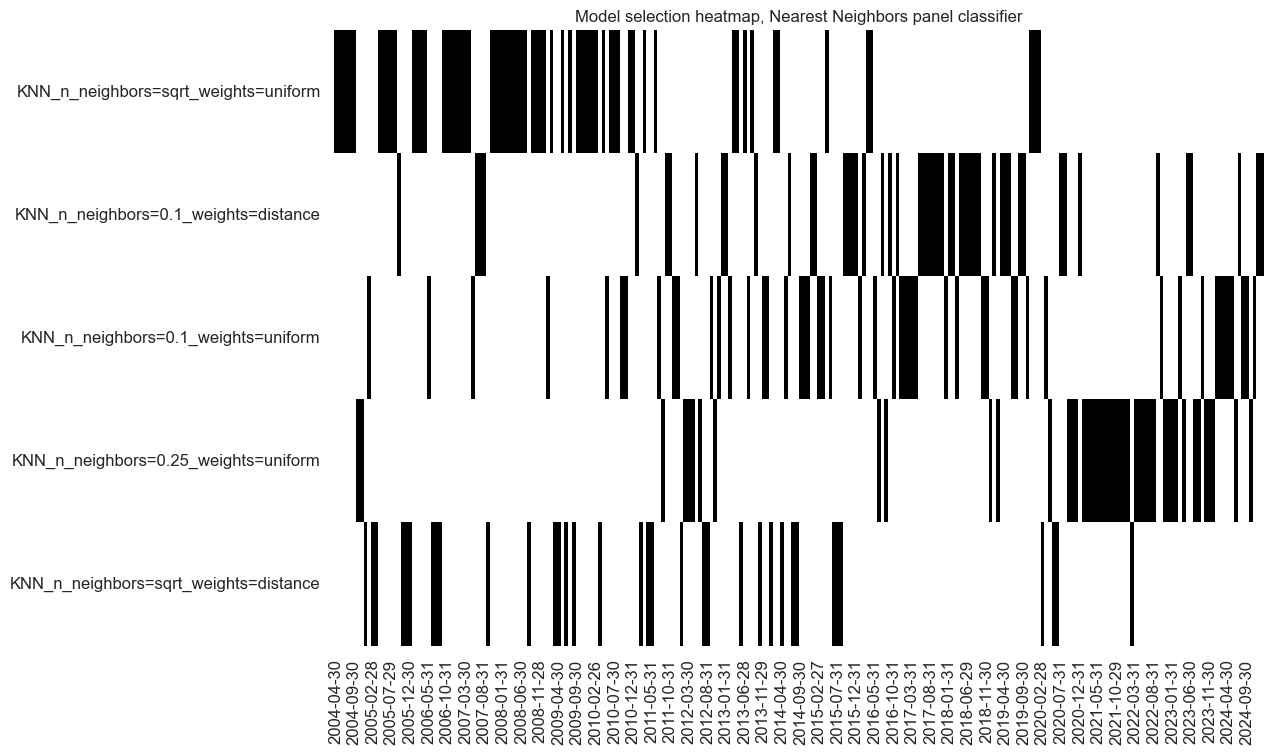

In [53]:
so_knn = msl.SignalOptimizer(
    df=dfx,
    xcats=factorz + ["CRXR_VT10"],
    cids=cids_cr,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    generate_labels=lambda x: 1 if x >= 0 else -1,
)

so_knn.calculate_predictions(
    name="KNN",
    models={
        "KNN": msl.KNNClassifier(),
    },
    hyperparameters={
        "KNN": {
            "n_neighbors": ["sqrt", 0.1, 0.25],
            "weights": ["uniform", "distance"],
        },
    },
    scorers=scorers,
    inner_splitters=splitters,
    min_cids=min_cids,
    min_periods=min_periods,  # 2 years
    test_size=test_size,
    n_jobs_outer=-1,
    cv_summary=cv_summary,
)

so_knn.models_heatmap(
    "KNN", title="Model selection heatmap, Nearest Neighbors panel classifier"
)

dfa = so_knn.get_optimized_signals("KNN")
dfx = msm.update_df(dfx, dfa)

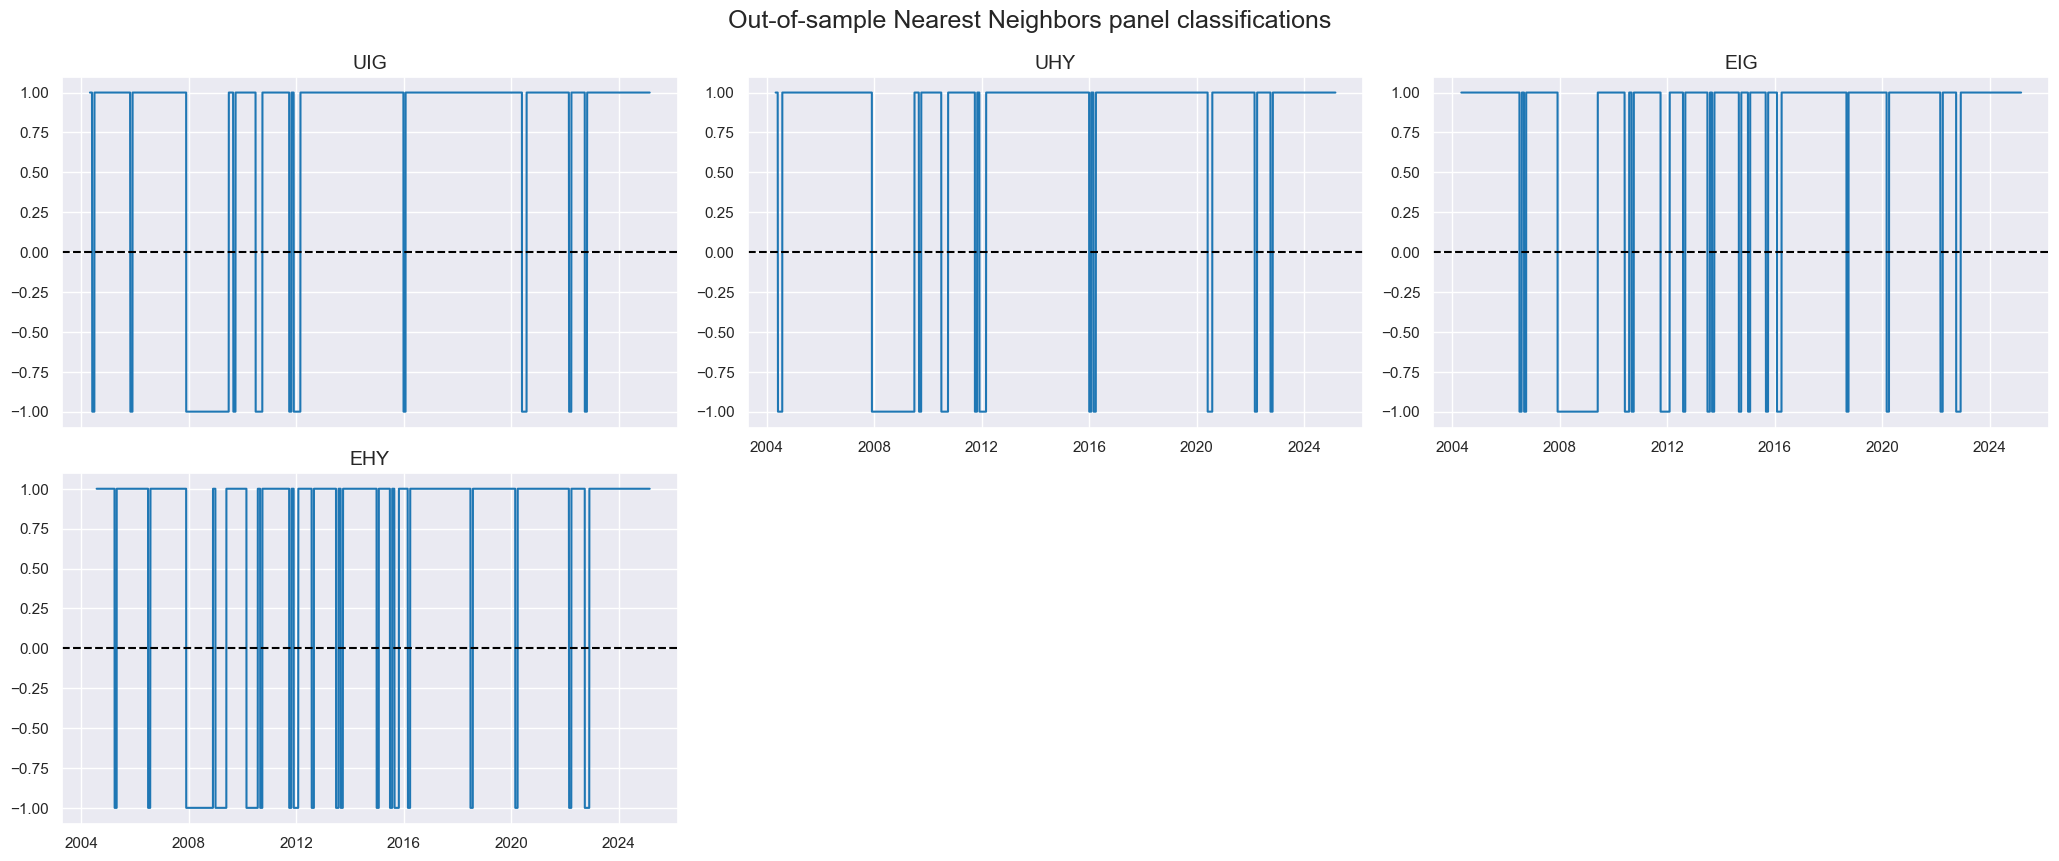

In [54]:
msp.view_timelines(
    df=dfx,
    title="Out-of-sample Nearest Neighbors panel classifications",
    xcats=["KNN"],
    cids=cids_cr,
    same_y=False,
)

#### Random forest

  0%|          | 0/84 [00:00<?, ?it/s]

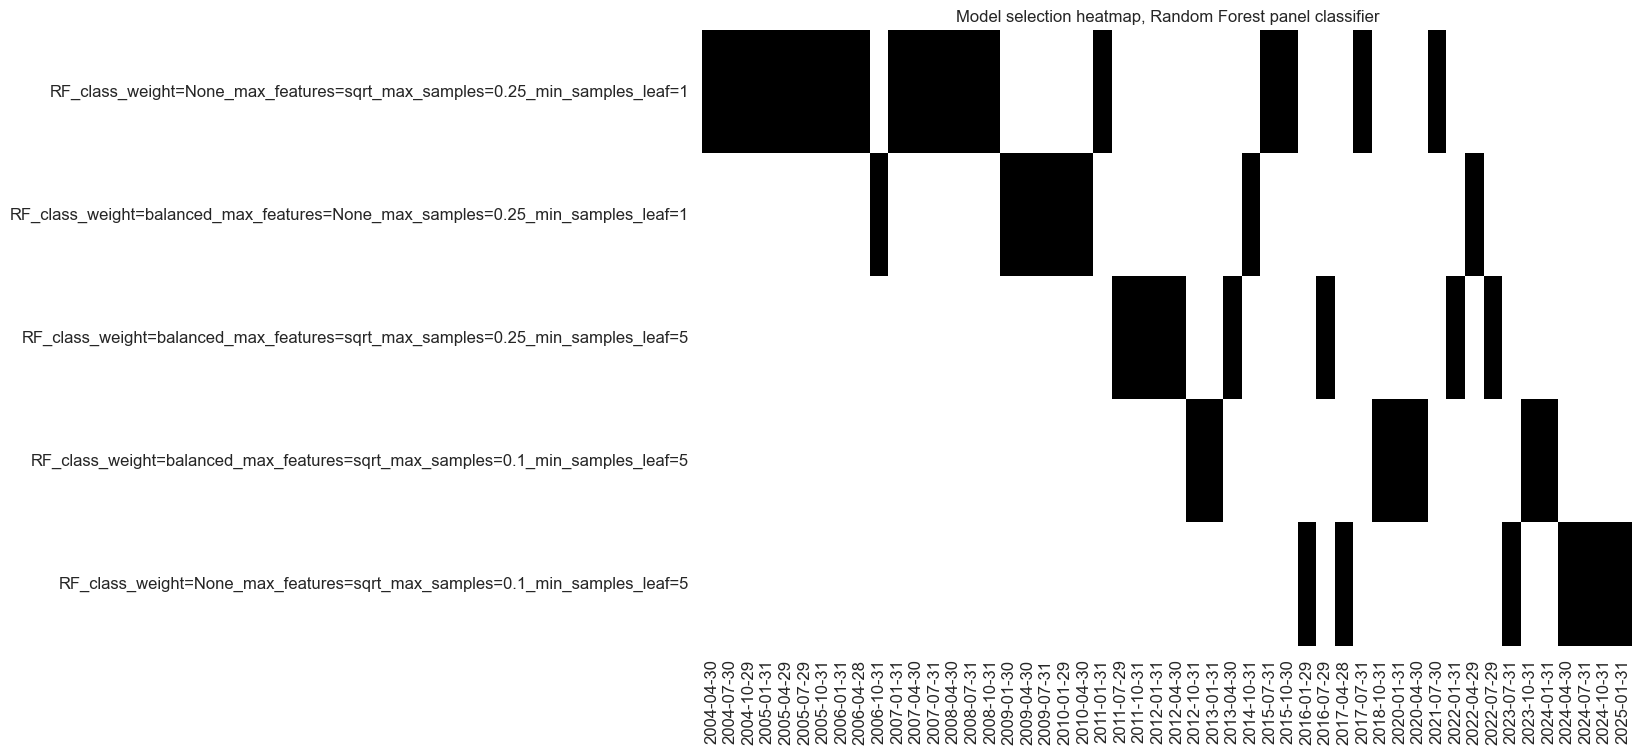

In [55]:
so_rf = msl.SignalOptimizer(
    df=dfx,
    xcats=factorz + ["CRXR_VT10"],
    cids=cids_cr,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    generate_labels=lambda x: 1 if x >= 0 else -1,
)

so_rf.calculate_predictions(
    name="RF",
    models={
        "RF": RandomForestClassifier(
            random_state=42,
            n_estimators=500,
        ),
    },
    hyperparameters={
        "RF": {
            "class_weight": [None, "balanced"],
            "max_features": ["sqrt", None],
            "max_samples": [0.25, 0.1],
            "min_samples_leaf": [1, 5],
        },
    },
    scorers=scorers,
    inner_splitters=splitters,
    cv_summary=cv_summary,
    min_cids=min_cids,
    min_periods=min_periods,  # 2 years
    test_size=3,
    split_functions=split_functions,
    n_jobs_outer=-1,
)

so_rf.models_heatmap(
    "RF", title="Model selection heatmap, Random Forest panel classifier"
)

dfa = so_rf.get_optimized_signals("RF")
dfx = msm.update_df(dfx, dfa)

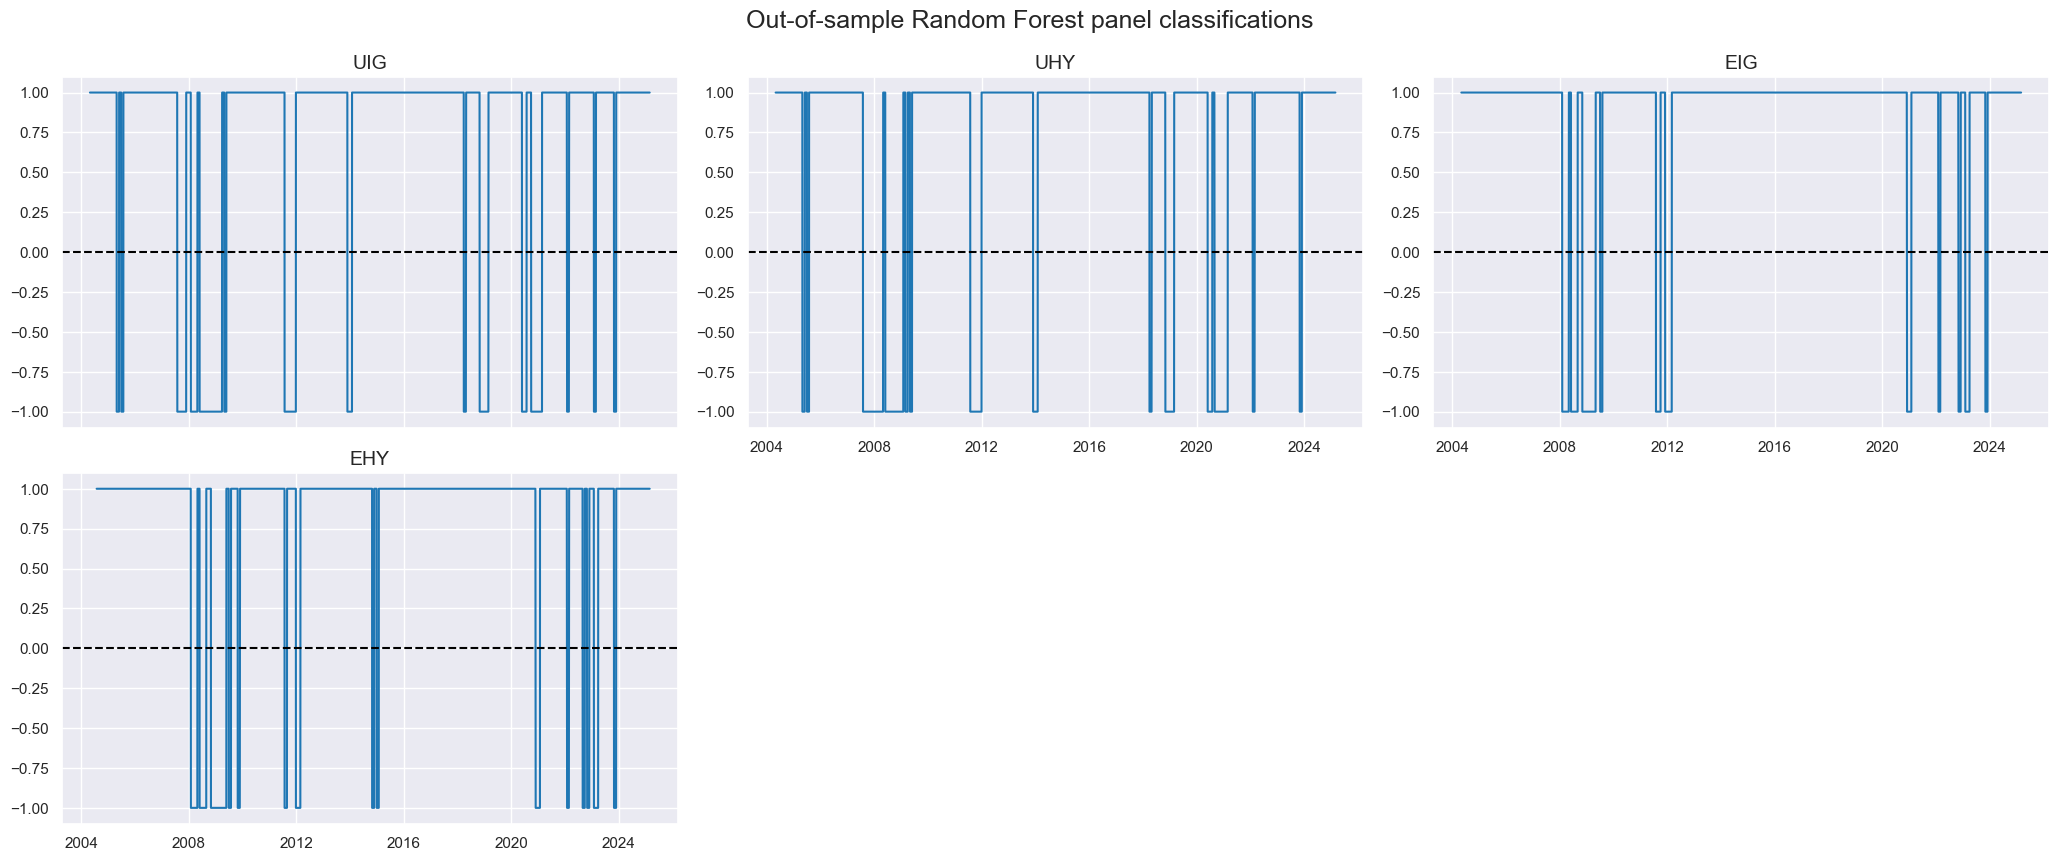

In [56]:
msp.view_timelines(
    df=dfx,
    title="Out-of-sample Random Forest panel classifications",
    xcats=["RF"],
    cids=cids_cr,
    same_y=False,
)

### Global signal

For each of the signals previously calculated, we use majority voting to determine a single global signal that is applied to all cross-sections.

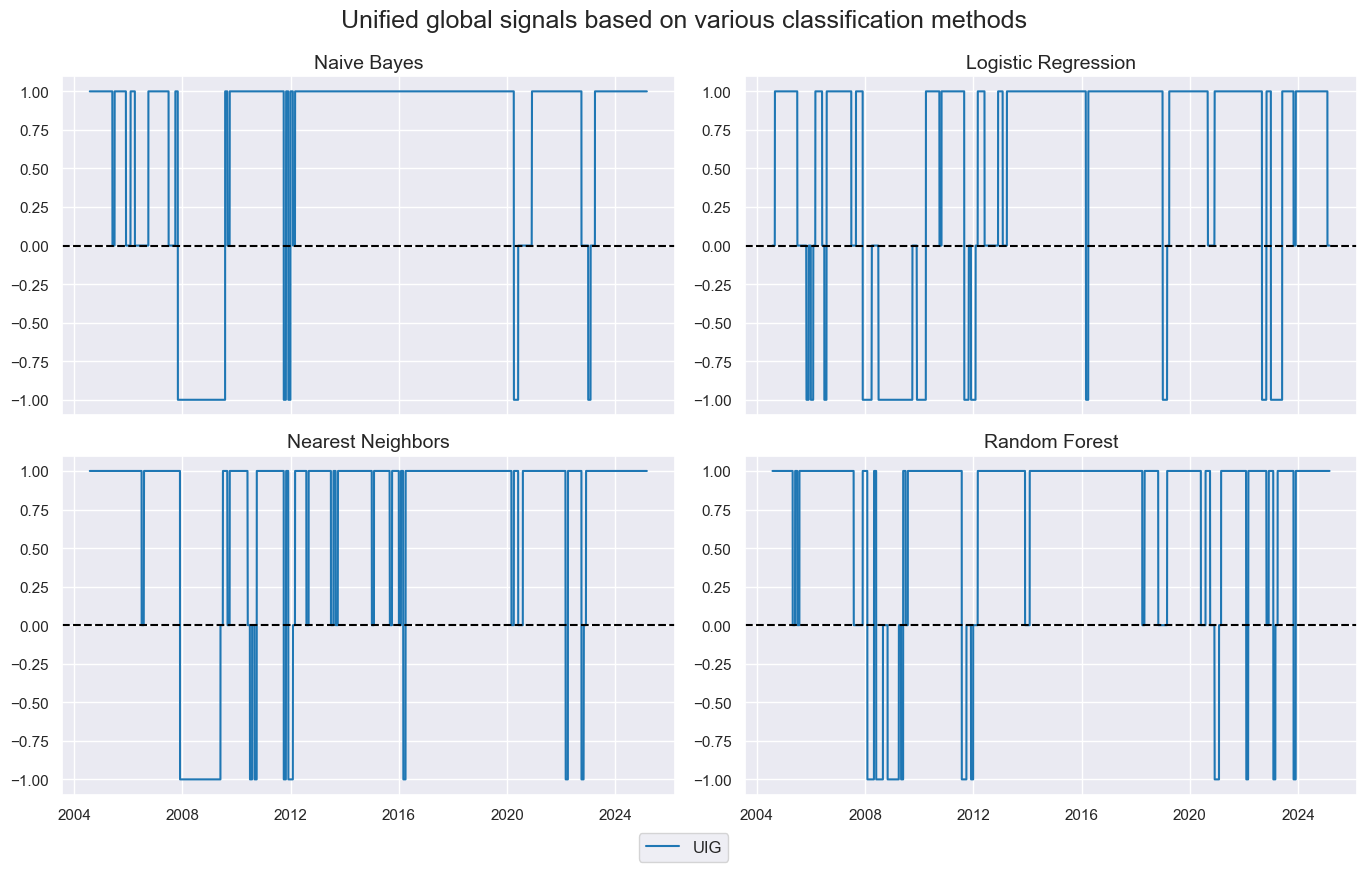

In [57]:
mods = ["NB", "LR", "KNN", "RF"]

for mod in mods:
    dfa = msp.panel_calculator(
        df=dfx,
        calcs=[f"{mod}_GLB = iEIG_{mod} + iEHY_{mod} + iUIG_{mod} + iUHY_{mod}"],
        cids=cids_cr,
    ).dropna()
    dfa["value"] = dfa["value"].apply(lambda x: 1 if x > 0 else -1 if x < 0 else 0)
    dfx = msm.update_df(dfx, dfa)

cidx = ["UIG"]
xcatx = [mod + "_GLB" for mod in mods]
msp.view_timelines(
    df=dfx,
    cids=cidx,
    xcats=xcatx,
    same_y=False,
    ncol=2,
    xcat_grid=True,
    title="Unified global signals based on various classification methods",
    xcat_labels=["Naive Bayes", "Logistic Regression", "Nearest Neighbors", "Random Forest"]
)

## Signal value checks

### Global signal

#### Accuracy check

In [58]:
## Compare optimized signals with simple average z-scores

srr = mss.SignalReturnRelations(
    df=dfx,
    rets=["CRXR_VT10"],
    sigs=["NB_GLB", "LR_GLB", "KNN_GLB", "RF_GLB"],
    cids=cids_cr,
    cosp=True,
    freqs=["M"],
    agg_sigs=["last"],
    start="2002-12-31",
    slip=1,
)

selcols = [
    "accuracy",
    "bal_accuracy",
    "pos_sigr",  # In the regime classification setting, this is less relevant
    "pos_retr",
]

srr.multiple_relations_table().round(3)  # [selcols]

accuracy  bal_accuracy  pos_sigr  \
Return    Signal  Frequency Aggregation                                     
CRXR_VT10 KNN_GLB M         last            0.622         0.531     0.887   
          LR_GLB  M         last            0.576         0.493     0.814   
          NB_GLB  M         last            0.627         0.555     0.883   
          RF_GLB  M         last            0.651         0.617     0.909   

                                         pos_retr  pos_prec  neg_prec  \
Return    Signal  Frequency Aggregation                                 
CRXR_VT10 KNN_GLB M         last            0.642     0.649     0.413   
          LR_GLB  M         last            0.627     0.624     0.362   
          NB_GLB  M         last            0.636     0.649     0.462   
          RF_GLB  M         last            0.637     0.658     0.575   

                                         pearson  pearson_pval  kendall  \
Return    Signal  Frequency Aggregation                                   
CRXR_VT10 KNN_GLB M         last           0.020         0.532    0.015   
          LR_GLB  M         last          -0.025         0.427   -0.036   
          NB_GLB  M         last           0.064         0.043    0.035   
          RF_GLB  M         last           0.085         0.007    0.055   

                                         kendall_pval    auc  
Return    Signal  Frequency Aggregation                       
CRXR_VT10 KNN_GLB M         last                0.561  0.514  
          LR_GLB  M         last                0.149  0.496  
          NB_GLB  M         last                0.166  0.525  
          RF_GLB  M         last                0.031  0.542

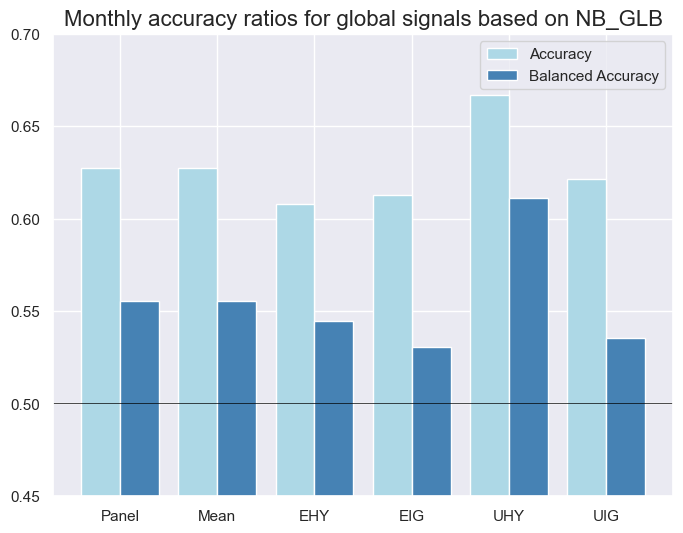

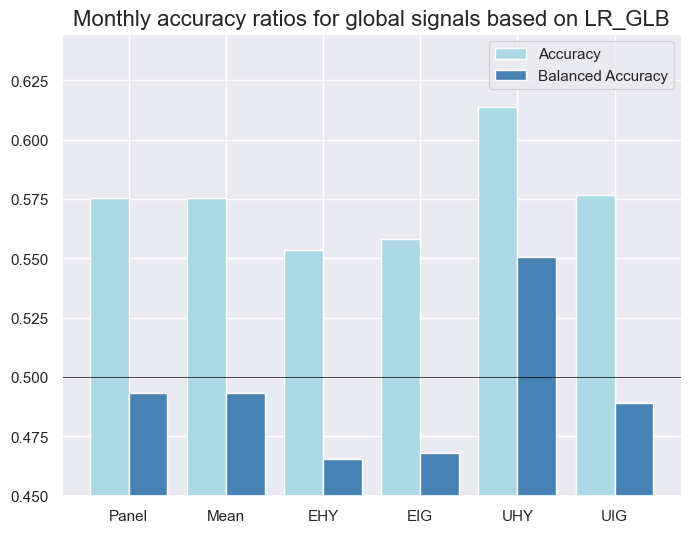

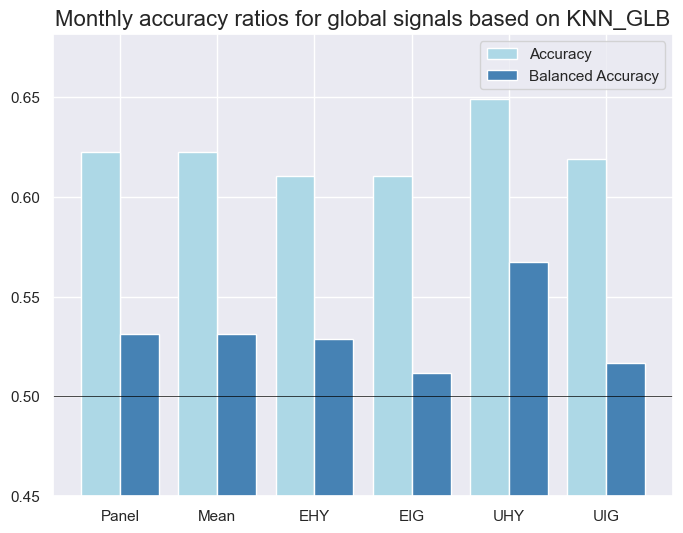

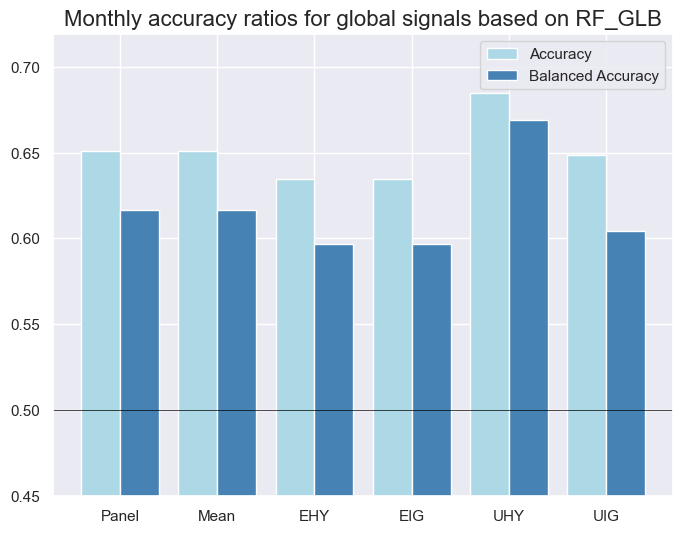

In [59]:
xcatx = ["NB_GLB", "LR_GLB", "KNN_GLB", "RF_GLB"]
for xcat in xcatx:
    srr.accuracy_bars(
        ret="CRXR_VT10",
        sigs=xcat,
        title=f"Monthly accuracy ratios for global signals based on {xcat}",
    )

#### Naive PnL

#### Simple notional positions

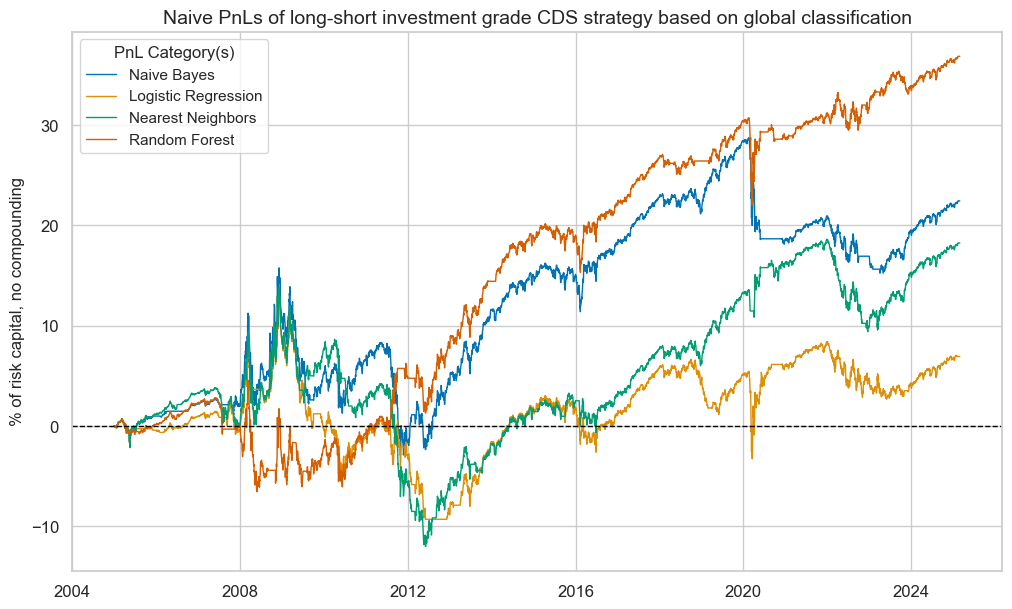

xcat                     PNL_NB_GLB PNL_LR_GLB PNL_KNN_GLB PNL_RF_GLB
Return %                     1.1135    0.34396     0.90514   1.828387
St. Dev. %                 3.923994   3.811226     3.74399   3.604658
Sharpe Ratio               0.283767   0.090249    0.241758   0.507229
Sortino Ratio              0.394816    0.12678    0.341422    0.72707
Max 21-Day Draw %         -8.675489  -8.675489   -6.362013  -8.675489
Max 6-Month Draw %       -11.285529 -10.279486  -11.152464  -8.985967
Peak to Trough Draw %    -18.698017 -22.894696  -25.831003 -11.118991
Top 5% Monthly PnL Share   1.422803   4.468367    1.781921   0.840486
USD_GB10YXR_NSA correl    -0.040796   0.010483   -0.040389  -0.088499
USD_EQXR_NSA correl        0.137493   0.095487    0.110031   0.236717
Traded Months                   243        243         243        243

In [60]:
sigx = ["NB_GLB", "LR_GLB", "KNN_GLB", "RF_GLB"]
cidx = cids_ig

pnls = msn.NaivePnL(
    df=dfx,
    ret="CRXR_NSA",
    sigs=sigx,
    cids=cidx,
    start="2004-12-31",
    bms=["USD_GB10YXR_NSA", "USD_EQXR_NSA"],
)
for sig in sigx:
    pnls.make_pnl(
        sig=sig,
        sig_op="raw",
        sig_add=0,
        sig_mult=1,
        rebal_freq="monthly",
        rebal_slip=1,
        # vol_scale=10,
    )

pnls.plot_pnls(
    title="Naive PnLs of long-short investment grade CDS strategy based on global classification",
    xcat_labels=[
        "Naive Bayes",
        "Logistic Regression",
        "Nearest Neighbors",
        "Random Forest",
    ],
    title_fontsize=14,
)
pnls.evaluate_pnls(pnl_cats=["PNL_" + sig for sig in sigx])

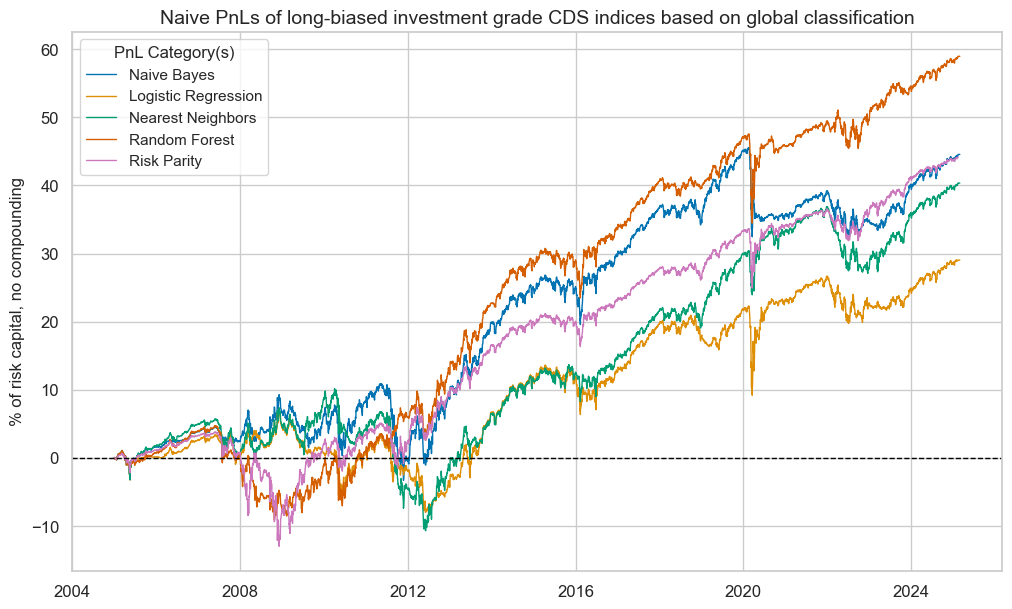

xcat                     PNL_NB_GLB PNL_LR_GLB PNL_KNN_GLB PNL_RF_GLB  \
Return %                   2.210535   1.440864    2.002175   2.925422   
St. Dev. %                 4.613926   4.375357     4.38808   4.626966   
Sharpe Ratio               0.479101   0.329313    0.456276   0.632255   
Sortino Ratio              0.671469   0.463916    0.653023   0.904603   
Max 21-Day Draw %        -13.013234 -13.013234   -6.403795 -13.013234   
Max 6-Month Draw %       -13.878189 -10.181213  -13.878189 -10.181212   
Peak to Trough Draw %    -14.194191 -15.090157  -20.853717 -13.804806   
Top 5% Monthly PnL Share    0.84618   1.168736    0.920672   0.635319   
USD_GB10YXR_NSA correl    -0.159647  -0.122637   -0.165843  -0.193545   
USD_EQXR_NSA correl         0.40958   0.391762     0.40159   0.476238   
Traded Months                   243        243         243        243   

xcat                      Long only  
Return %                   2.197246  
St. Dev. %                 4.062352  
Sharpe Ratio                0.54088  
Sortino Ratio              0.772765  
Max 21-Day Draw %         -8.675489  
Max 6-Month Draw %       -11.587299  
Peak to Trough Draw %    -16.774382  
Top 5% Monthly PnL Share   0.750353  
USD_GB10YXR_NSA correl    -0.284131  
USD_EQXR_NSA correl         0.66547  
Traded Months                   243

In [61]:
sigx = ["NB_GLB", "LR_GLB", "KNN_GLB", "RF_GLB"]
cidx = cids_ig

pnls = msn.NaivePnL(
    df=dfx,
    ret="CRXR_NSA",
    sigs=sigx,
    cids=cidx,
    start="2004-12-31",
    bms=["USD_GB10YXR_NSA", "USD_EQXR_NSA"],
)
for sig in sigx:
    pnls.make_pnl(
        sig=sig,
        sig_op="raw",
        sig_add=0.5,
        sig_mult=1,
        rebal_freq="monthly",
        neutral="zero",
        rebal_slip=1,
        # vol_scale=10,
    )

pnls.make_long_pnl(vol_scale=None, label="Long only")

pnls.plot_pnls(
    title="Naive PnLs of long-biased investment grade CDS indices based on global classification",
    xcat_labels=[
        "Naive Bayes",
        "Logistic Regression",
        "Nearest Neighbors",
        "Random Forest",
        "Risk Parity",
    ],
    title_fontsize=14,
)
pnls.evaluate_pnls(pnl_cats=["PNL_" + sig for sig in sigx] + ["Long only"])

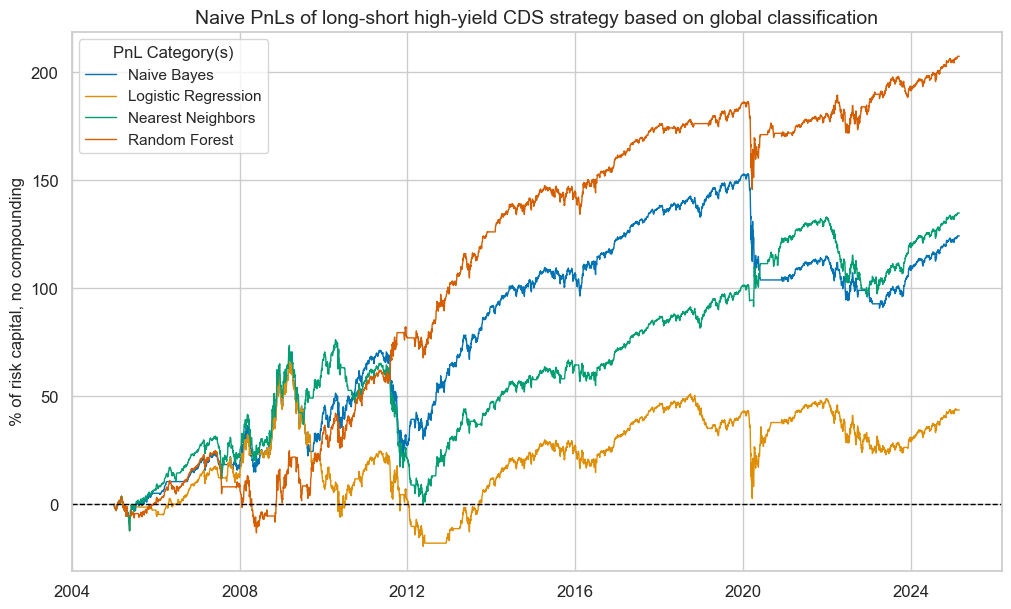

xcat                     PNL_NB_GLB PNL_LR_GLB PNL_KNN_GLB PNL_RF_GLB
Return %                    6.16179   2.167904    6.687169   10.28211
St. Dev. %                14.211154  14.073087   13.542657  13.495598
Sharpe Ratio               0.433588   0.154046    0.493786   0.761886
Sortino Ratio              0.601779   0.215091    0.704502   1.108458
Max 21-Day Draw %        -39.639918 -39.639918  -26.586614 -39.639918
Max 6-Month Draw %       -49.101137  -47.66054  -49.617112 -34.852224
Peak to Trough Draw %    -62.150898 -87.427533  -76.457663 -40.547029
Top 5% Monthly PnL Share   0.976613    2.53217    0.926796     0.5849
USD_GB10YXR_NSA correl    -0.077215  -0.026741    -0.07579  -0.103725
USD_EQXR_NSA correl        0.235123   0.192853      0.2118   0.323852
Traded Months                   243        243         243        243

In [62]:
sigx = ["NB_GLB", "LR_GLB", "KNN_GLB", "RF_GLB"]
cidx = cids_hy

pnls = msn.NaivePnL(
    df=dfx,
    ret="CRXR_NSA",
    sigs=sigx,
    cids=cidx,
    start="2004-12-31",
    bms=["USD_GB10YXR_NSA", "USD_EQXR_NSA"],
)
for sig in sigx:
    pnls.make_pnl(
        sig=sig,
        sig_op="raw",
        sig_add=0,
        sig_mult=1,
        rebal_freq="monthly",
        rebal_slip=1,
        # vol_scale=10,
    )

pnls.plot_pnls(
    title="Naive PnLs of long-short high-yield CDS strategy based on global classification",
    xcat_labels=[
        "Naive Bayes",
        "Logistic Regression",
        "Nearest Neighbors",
        "Random Forest",
    ],
    title_fontsize=14,
)
pnls.evaluate_pnls(pnl_cats=["PNL_" + sig for sig in sigx])

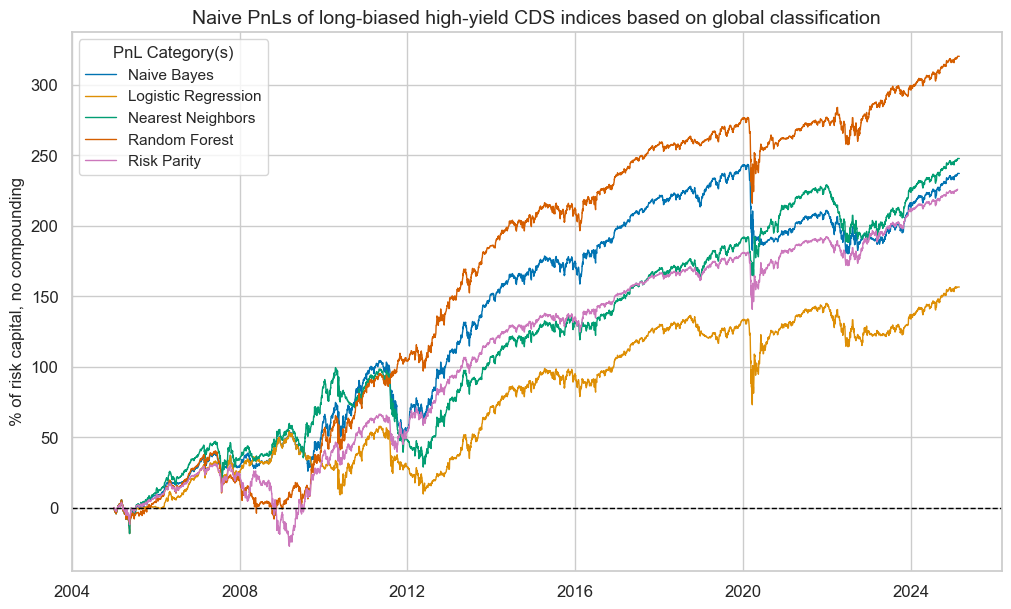

xcat                     PNL_NB_GLB PNL_LR_GLB PNL_KNN_GLB PNL_RF_GLB  \
Return %                  11.761003   7.766294   12.286382  15.881324   
St. Dev. %                17.970533  17.456844   17.493044  18.323209   
Sharpe Ratio                0.65446   0.444885    0.702358   0.866733   
Sortino Ratio              0.919374   0.627657    1.018234   1.254654   
Max 21-Day Draw %        -59.459877 -59.459877  -29.327088 -59.459877   
Max 6-Month Draw %       -57.168804 -52.278336  -57.168804 -52.278336   
Peak to Trough Draw %    -63.390562 -63.327214  -70.537047 -60.820544   
Top 5% Monthly PnL Share   0.666926   0.839744    0.650882   0.499943   
USD_GB10YXR_NSA correl    -0.171953  -0.135708   -0.172593  -0.185153   
USD_EQXR_NSA correl        0.478861   0.456983    0.464891   0.525815   
Traded Months                   243        243         243        243   

xcat                      Long only  
Return %                  11.229509  
St. Dev. %                14.964405  
Sharpe Ratio               0.750415  
Sortino Ratio              1.082005  
Max 21-Day Draw %        -39.639918  
Max 6-Month Draw %       -46.216449  
Peak to Trough Draw %    -58.497244  
Top 5% Monthly PnL Share   0.612759  
USD_GB10YXR_NSA correl    -0.266613  
USD_EQXR_NSA correl        0.704258  
Traded Months                   243

In [63]:
sigx = ["NB_GLB", "LR_GLB", "KNN_GLB", "RF_GLB"]

cidx = cids_hy

pnls = msn.NaivePnL(
    df=dfx,
    ret="CRXR_NSA",
    sigs=sigx,
    cids=cidx,
    start="2004-12-31",
    bms=["USD_GB10YXR_NSA", "USD_EQXR_NSA"],
)
for sig in sigx:
    pnls.make_pnl(
        sig=sig,
        sig_op="raw",
        sig_add=0.5,
        sig_mult=1,
        rebal_freq="monthly",
        neutral="zero",
        rebal_slip=1,
    )

pnls.make_long_pnl(vol_scale=None, label="Long only")

pnls.plot_pnls(
    title="Naive PnLs of long-biased high-yield CDS indices based on global classification",
    xcat_labels=[
        "Naive Bayes",
        "Logistic Regression",
        "Nearest Neighbors",
        "Random Forest",
        "Risk Parity",
    ],
    title_fontsize=14,
)
pnls.evaluate_pnls(pnl_cats=["PNL_" + sig for sig in sigx] + ["Long only"])

#### Vol-targeted positions

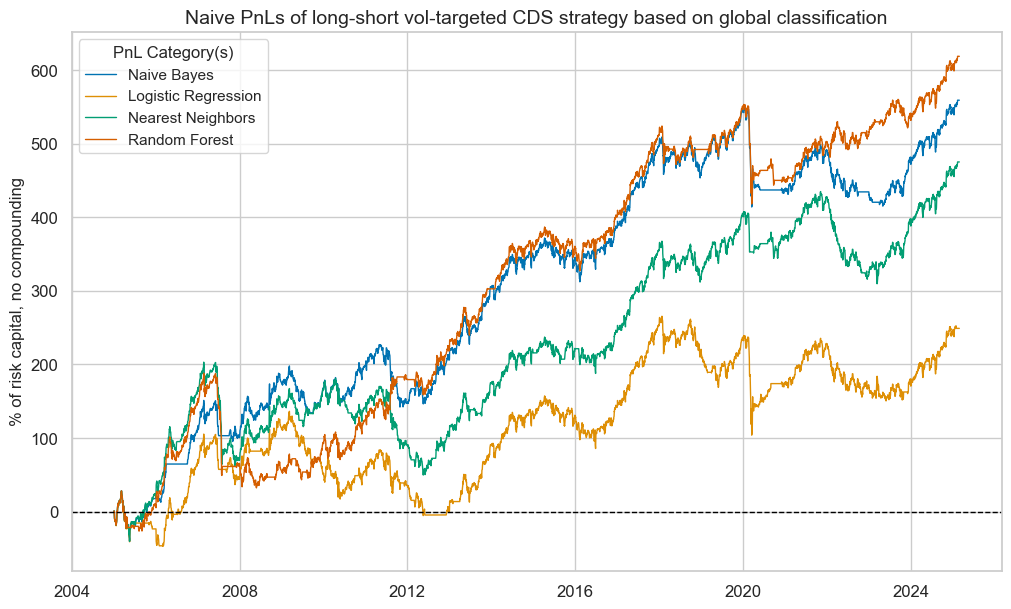

xcat                      PNL_NB_GLB  PNL_LR_GLB PNL_KNN_GLB  PNL_RF_GLB
Return %                     27.7292   12.354446   23.566767   30.687774
St. Dev. %                 41.950404   42.279782   42.283466   42.102334
Sharpe Ratio                   0.661    0.292207    0.557352    0.728885
Sortino Ratio               0.923061    0.402578    0.768317    1.007949
Max 21-Day Draw %        -131.548465 -131.548465  -99.790888 -131.548465
Max 6-Month Draw %       -112.129873  -97.473066 -136.836688 -126.658224
Peak to Trough Draw %     -135.27724 -161.496618 -153.396012 -155.734608
Top 5% Monthly PnL Share     0.57854    1.265093    0.708539    0.535343
USD_GB10YXR_NSA correl     -0.112624   -0.062484   -0.104992   -0.130934
USD_EQXR_NSA correl         0.385619    0.322484    0.336628     0.39962
Traded Months                    243         243         243         243

In [64]:
sigx = ["NB_GLB", "LR_GLB", "KNN_GLB", "RF_GLB"]
cidx = cids_cr

pnls = msn.NaivePnL(
    df=dfx,
    ret="CRXR_VT10",
    sigs=sigx,
    cids=cidx,
    start="2004-12-31",
    bms=["USD_GB10YXR_NSA", "USD_EQXR_NSA"],
)
for sig in sigx:
    pnls.make_pnl(
        sig=sig,
        sig_op="raw",
        sig_add=0,
        sig_mult=1,
        rebal_freq="monthly",
        rebal_slip=1,
        # vol_scale=10,
    )

pnls.plot_pnls(
    title="Naive PnLs of long-short vol-targeted CDS strategy based on global classification",
    xcat_labels=[
        "Naive Bayes",
        "Logistic Regression",
        "Nearest Neighbors",
        "Random Forest",
    ],
    title_fontsize=14,
)
pnls.evaluate_pnls(pnl_cats=["PNL_" + sig for sig in sigx])

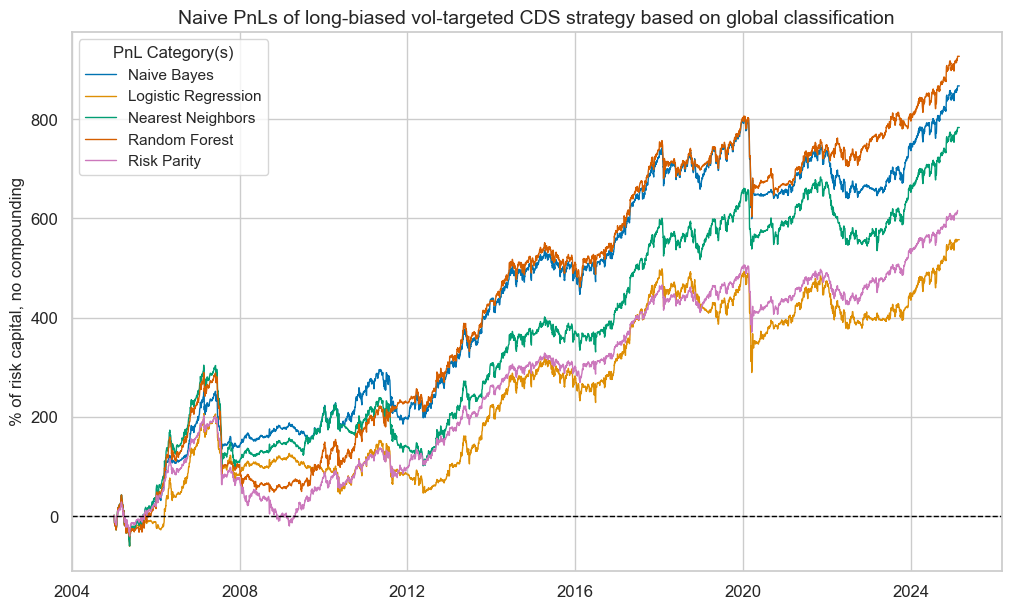

xcat                      PNL_NB_GLB  PNL_LR_GLB PNL_KNN_GLB  PNL_RF_GLB  \
Return %                   43.008034   27.628583   38.845601   45.966608   
St. Dev. %                 60.388502   58.949964   60.693853   61.357101   
Sharpe Ratio                0.712189    0.468679    0.640025    0.749165   
Sortino Ratio               0.989813    0.644445    0.881049    1.029408   
Max 21-Day Draw %        -197.322698 -197.322698 -149.686332 -197.322698   
Max 6-Month Draw %       -155.153581 -146.209599 -205.255032 -193.352536   
Peak to Trough Draw %     -202.91586 -209.055207 -210.521833 -240.800116   
Top 5% Monthly PnL Share    0.541493    0.818627    0.625465     0.50274   
USD_GB10YXR_NSA correl     -0.165709   -0.134411   -0.160176   -0.175936   
USD_EQXR_NSA correl         0.502504     0.47159    0.467962    0.505134   
Traded Months                    243         243         243         243   

xcat                       Long only  
Return %                   30.620536  
St. Dev. %                 44.971252  
Sharpe Ratio                0.680891  
Sortino Ratio               0.937405  
Max 21-Day Draw %        -131.548465  
Max 6-Month Draw %       -136.836688  
Peak to Trough Draw %    -222.216642  
Top 5% Monthly PnL Share    0.532601  
USD_GB10YXR_NSA correl     -0.235164  
USD_EQXR_NSA correl         0.630778  
Traded Months                    243

In [65]:
sigx = ["NB_GLB", "LR_GLB", "KNN_GLB", "RF_GLB"]
cidx = cids_cr

pnls = msn.NaivePnL(
    df=dfx,
    ret="CRXR_VT10",
    sigs=sigx,
    cids=cidx,
    start="2004-12-31",
    bms=["USD_GB10YXR_NSA", "USD_EQXR_NSA"],
)
for sig in sigx:
    pnls.make_pnl(
        sig=sig,
        sig_op="raw",
        sig_add=0.5,
        sig_mult=1,
        rebal_freq="monthly",
        neutral="zero",
        rebal_slip=1,
        # vol_scale=10,
    )

pnls.make_long_pnl(vol_scale=None, label="Long only")

pnls.plot_pnls(
    title="Naive PnLs of long-biased vol-targeted CDS strategy based on global classification",
    xcat_labels=[
        "Naive Bayes",
        "Logistic Regression",
        "Nearest Neighbors",
        "Random Forest",
        "Risk Parity",
    ],
    title_fontsize=14,
)
pnls.evaluate_pnls(pnl_cats=["PNL_" + sig for sig in sigx] + ["Long only"])